In [1]:
import pandas as pd
import scanpy as sc
import numpy as np
import CococoNet_reader
from scipy import sparse
import Name_resolver
import os


In [2]:
np.random.seed(401)

In [3]:
def get_one_to_ones(Species_1 = 'rice',Species_2 = 'maize'):

    import pandas as pd
    import CococoNet_reader
    #Get Species Names in Common form 
    common_name_1 = Name_resolver.species_name_resolver(Species_1,'common')
    common_name_2 = Name_resolver.species_name_resolver(Species_2,'common')

    if common_name_1 == 'rice':
        common_name_1 = 'rice_jp'
    if common_name_2 == 'rice':
        common_name_2 ='rice_jp'
    file_list = os.listdir('/data/passala/OrthoDB_data/V_11_pairwise_maps_fixed_problem_species')
    spec_1_filter = [i for i in file_list if common_name_1 in i]
    spec_2_filter = [i for i in spec_1_filter if common_name_2 in i]
    current_location = '/data/passala/OrthoDB_data/V_11_pairwise_maps_fixed_problem_species/' + spec_2_filter[0]
    
    cross_species_n_m_genes = pd.read_csv(current_location)

    ### Get one to ones
    cross_species_map_one_to_one = cross_species_n_m_genes.drop_duplicates(subset=common_name_1 + ' Symbol', keep= False,)
    cross_species_map_one_to_one = cross_species_map_one_to_one.drop_duplicates(subset= common_name_2 + ' Symbol', keep= False)
    return cross_species_map_one_to_one

In [4]:
test = get_one_to_ones()

In [5]:
test = test.rename(columns = {'rice_jp Symbol':'Rice Gene','maize Symbol':'Maize Gene'})[['Maize Gene','Rice Gene']]

In [6]:
test

Maize Gene     Rice Gene
4      Zm00001d027886  Os05g0333200
10       LOC100279759  Os08g0137200
20       LOC100273771  Os01g0575500
23       LOC100383681    LOC4334163
28       LOC103633462    LOC4345331
...               ...           ...
70269  Zm00001d045383    LOC4340090
70270    LOC100382750    LOC4326933
70271    LOC100275174  Os02g0232400
70272    LOC100275271    LOC4329688
70273  Zm00001d038807  Os05g0519500

[5625 rows x 2 columns]

In [7]:
# co_expressalog_map_85 = pd.read_csv('/data/passala/Generated_Tables/Maize_Rice_integration/maize_rice_one_to_one.csv')
# co_expressalog_map_85 = co_expressalog_map_85[['maize','rice']]
# co_expressalog_map_85 = co_expressalog_map_85.rename(columns = {'maize':'Maize Gene','rice':'Rice Gene'})
# co_expressalog_map_85

co_expressalog_map_85 = test

In [8]:
co_expressalog_map_85 = co_expressalog_map_85.drop_duplicates(subset = 'Rice Gene')
co_expressalog_map_85 = co_expressalog_map_85.drop_duplicates(subset = 'Maize Gene')
co_expressalog_map_85

Maize Gene     Rice Gene
4      Zm00001d027886  Os05g0333200
10       LOC100279759  Os08g0137200
20       LOC100273771  Os01g0575500
23       LOC100383681    LOC4334163
28       LOC103633462    LOC4345331
...               ...           ...
70269  Zm00001d045383    LOC4340090
70270    LOC100382750    LOC4326933
70271    LOC100275174  Os02g0232400
70272    LOC100275271    LOC4329688
70273  Zm00001d038807  Os05g0519500

[5625 rows x 2 columns]

In [9]:
maize_cccnt = CococoNet_reader.read_cococonet('maize')


In [10]:
rice_sc_data = sc.read_10x_mtx('/data/passala/Collaborator_Data/GEO_sourced_single_cell_for_CRUSH/Rice_japonica/Cell_ranger_results/Rice_paper/outs/filtered_feature_bc_matrix',cache=True)

In [11]:
maize_Data = sc.read_10x_mtx('/data/passala/Collaborator_Data/GEO_sourced_single_cell_for_CRUSH/Maize_nitrate_root_SC/Cell_ranger_output_folder/Full_output/cells_with_nitrate/outs/filtered_feature_bc_matrix', cache = True)

In [12]:
rice_sc_data.var

gene_ids    feature_types
Os01g0100100  Os01g0100100  Gene Expression
Os01g0100200  Os01g0100200  Gene Expression
Os01g0100300  Os01g0100300  Gene Expression
Os01g0100400  Os01g0100400  Gene Expression
Os01g0100466  Os01g0100466  Gene Expression
...                    ...              ...
Os12g0641200  Os12g0641200  Gene Expression
Os12g0641300  Os12g0641300  Gene Expression
Os12g0641400  Os12g0641400  Gene Expression
Os12g0641500  Os12g0641500  Gene Expression
Os12g0641600  Os12g0641600  Gene Expression

[37863 rows x 2 columns]

In [13]:
maize_Data.var['In CoCoCoNet'] = 0
maize_Data.var['In CoCoCoNet'].loc[maize_Data.var['gene_ids'].isin(maize_cccnt.index)] = 1
#maize_Data = maize_Data[:,maize_Data.var['In CoCoCoNet'] == 1]
maize_Data

/tmp/ipykernel_2457097/898070478.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  maize_Data.var['In CoCoCoNet'].loc[maize_Data.var['gene_ids'].isin(maize_cccnt.index)] = 1


AnnData object with n_obs × n_vars = 4101 × 46430
    var: 'gene_ids', 'feature_types', 'In CoCoCoNet'

In [14]:
sc.pp.filter_cells(maize_Data, min_genes=200)
sc.pp.filter_genes(maize_Data, min_cells=2)

In [15]:
maize_Data

AnnData object with n_obs × n_vars = 4100 × 25653
    obs: 'n_genes'
    var: 'gene_ids', 'feature_types', 'In CoCoCoNet', 'n_cells'

In [16]:
sc.pp.normalize_total(maize_Data, target_sum=1e4)
sc.pp.log1p(maize_Data)


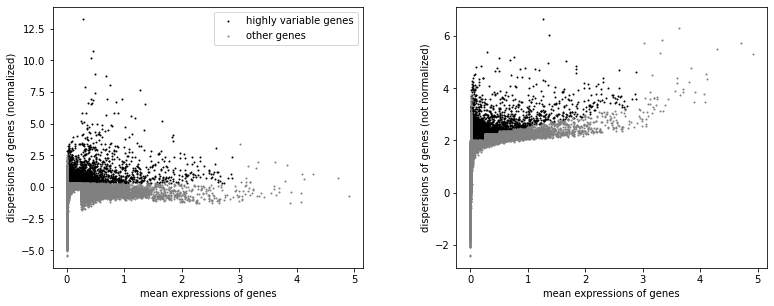

In [17]:

sc.pp.highly_variable_genes(maize_Data, min_mean=0.0125, max_mean=3, min_disp=0.3) # disp .5
sc.pl.highly_variable_genes(maize_Data)

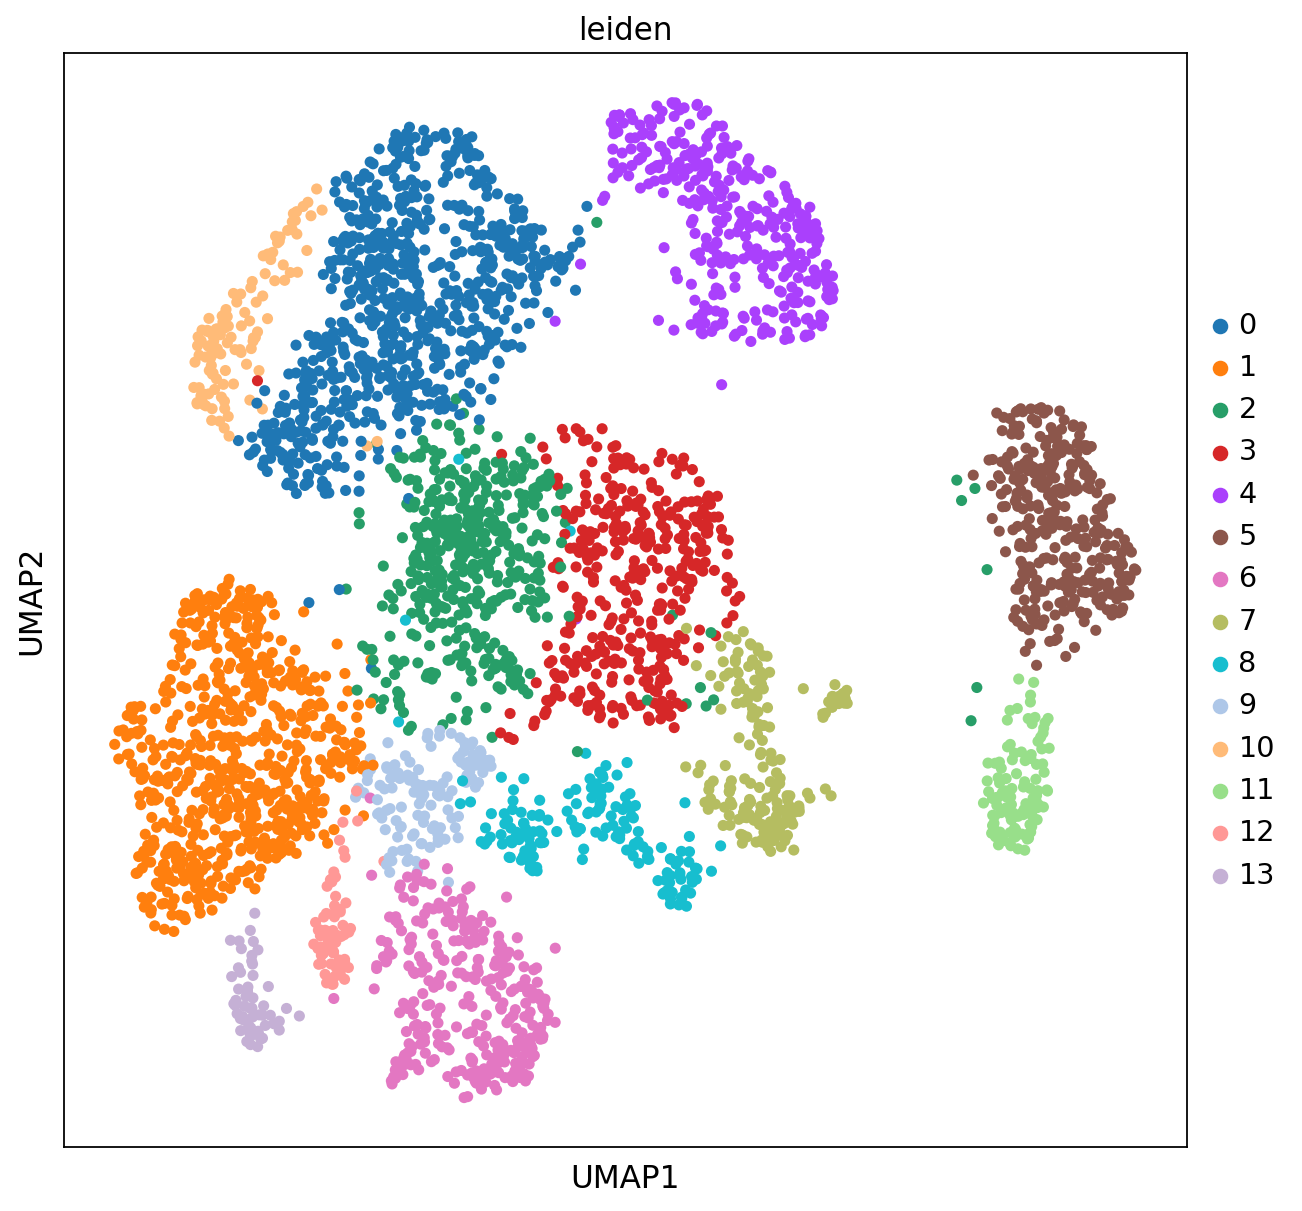

In [18]:
sc.set_figure_params(facecolor = 'white', figsize = (9,9))
sc.tl.pca(maize_Data, svd_solver='arpack', random_state= 200)
sc.pp.neighbors(maize_Data, n_neighbors=30, n_pcs=50, random_state= 500)
sc.tl.umap(maize_Data, random_state= 221)
sc.tl.leiden(maize_Data, random_state= 1000, resolution= .6)

sc.pl.umap(maize_Data, color = 'leiden', s=100)

In [19]:
maize_Data.var

gene_ids    feature_types  In CoCoCoNet  \
Zm00001d027230                 Zm00001d027230  Gene Expression             0   
Zm00001d027231                 Zm00001d027231  Gene Expression             1   
Zm00001d027233                 Zm00001d027233  Gene Expression             1   
Zm00001d027236                 Zm00001d027236  Gene Expression             1   
Zm00001d027239                 Zm00001d027239  Gene Expression             1   
...                                       ...              ...           ...   
SSU_rRNA_eukarya-106          ENSRNA049478534  Gene Expression             1   
5_8S_rRNA-57                  ENSRNA049478548  Gene Expression             0   
SSU_rRNA_eukarya-107          ENSRNA049478530  Gene Expression             1   
OVATE-transcription factor 3   Zm00001d000458  Gene Expression             0   
Zm00001d000460                 Zm00001d000460  Gene Expression             0   

                              n_cells  highly_variable     means  dispersions  \
Zm00001d027230                     67            False  0.024387     1.696221   
Zm00001d027231                    290             True  0.241811     2.104409   
Zm00001d027233                      2            False  0.000593     0.203313   
Zm00001d027236                     36             True  0.021745     2.032777   
Zm00001d027239                     60            False  0.023626     1.419417   
...                               ...              ...       ...          ...   
SSU_rRNA_eukarya-106               67             True  0.090445     2.502171   
5_8S_rRNA-57                        8            False  0.010975     2.160190   
SSU_rRNA_eukarya-107              217             True  0.307557     2.541439   
OVATE-transcription factor 3        2            False  0.000167    -0.994376   
Zm00001d000460                      4            False  0.001130     0.942761   

                              dispersions_norm  
Zm00001d027230                       -0.095275  
Zm00001d027231                        0.435565  
Zm00001d027233                       -2.036773  
Zm00001d027236                        0.342410  
Zm00001d027239                       -0.455253  
...                                        ...  
SSU_rRNA_eukarya-106                  0.952848  
5_8S_rRNA-57                          0.508108  
SSU_rRNA_eukarya-107                  1.507421  
OVATE-transcription factor 3         -3.594344  
Zm00001d000460                       -1.075135  

[25653 rows x 8 columns]

In [20]:
#sc.pl.umap(maize_Data, color = ['leiden','Zm00001d024960'], s=80, legend_loc = 'on data')# Epidermis

In [21]:
#sc.pl.umap(maize_Data, color = ['leiden','Zm00001d038325'], s=80, legend_loc = 'on data')# Epidermis

In [22]:
#sc.pl.umap(maize_Data, color = ['leiden','Zm00001d040257'], s=80, legend_loc = 'on data')# stele

In [23]:
#sc.pl.umap(maize_Data, color = ['leiden','Zm00001d018029'], s=80, legend_loc = 'on data')# endodermis

In [24]:
maize_Data.obs['Cell Cluster Annotation'] = 'Not Annotated'
maize_Data.obs['Cell Cluster Annotation'].loc[maize_Data.obs['leiden'] == '5'] = 'Epidermis'
maize_Data.obs['Cell Cluster Annotation'].loc[maize_Data.obs['leiden'].isin(['0','2','3','10'])] = 'Cortex'
maize_Data.obs['Cell Cluster Annotation'].loc[maize_Data.obs['leiden'].isin(['1'])] = 'Stele'
maize_Data.obs['Cell Cluster Annotation'].loc[maize_Data.obs['leiden'].isin(['4'])] = 'Exodermis'
maize_Data.obs['Cell Cluster Annotation'].loc[maize_Data.obs['leiden'].isin(['6'])] = 'CC'
maize_Data.obs['Cell Cluster Annotation'].loc[maize_Data.obs['leiden'].isin(['7'])] = 'Meristem'

maize_Data.obs['Cell Cluster Annotation'].loc[maize_Data.obs['leiden'].isin(['9'])] = 'Pericycle'
maize_Data.obs['Cell Cluster Annotation'].loc[maize_Data.obs['leiden'].isin(['11'])] = 'Root Hair'
maize_Data.obs['Cell Cluster Annotation'].loc[maize_Data.obs['leiden'].isin(['12'])] = 'Endodermis'
maize_Data.obs['Cell Cluster Annotation'].loc[maize_Data.obs['leiden'].isin(['13'])] = 'Protophloem'




/tmp/ipykernel_2457097/1510908982.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  maize_Data.obs['Cell Cluster Annotation'].loc[maize_Data.obs['leiden'] == '5'] = 'Epidermis'
/tmp/ipykernel_2457097/1510908982.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  maize_Data.obs['Cell Cluster Annotation'].loc[maize_Data.obs['leiden'].isin(['0','2','3','10'])] = 'Cortex'
/tmp/ipykernel_2457097/1510908982.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-v

In [25]:
rice_sc_data.var_names_make_unique()

In [26]:
rice_sc_data.var_names

Index(['Os01g0100100', 'Os01g0100200', 'Os01g0100300', 'Os01g0100400',
       'Os01g0100466', 'Os01g0100500', 'Os01g0100600', 'Os01g0100650',
       'Os01g0100700', 'Os01g0100800',
       ...
       'Os12g0640800', 'Os12g0640900', 'Os12g0640951', 'Os12g0640950',
       'Os12g0641100', 'Os12g0641200', 'Os12g0641300', 'Os12g0641400',
       'Os12g0641500', 'Os12g0641600'],
      dtype='object', length=37863)

In [27]:
sc.pp.normalize_total(rice_sc_data, target_sum=1e4)

sc.pp.log1p(rice_sc_data)

In [28]:
sc.pp.highly_variable_genes(rice_sc_data, min_mean=0.0125, max_mean=3, min_disp=.2)
#dispersion .5

In [29]:
sc.set_figure_params(facecolor = 'white', figsize = (9,9)) # Make figures bigger and on a white background because your PI is 70 and doesn't know what a .png is


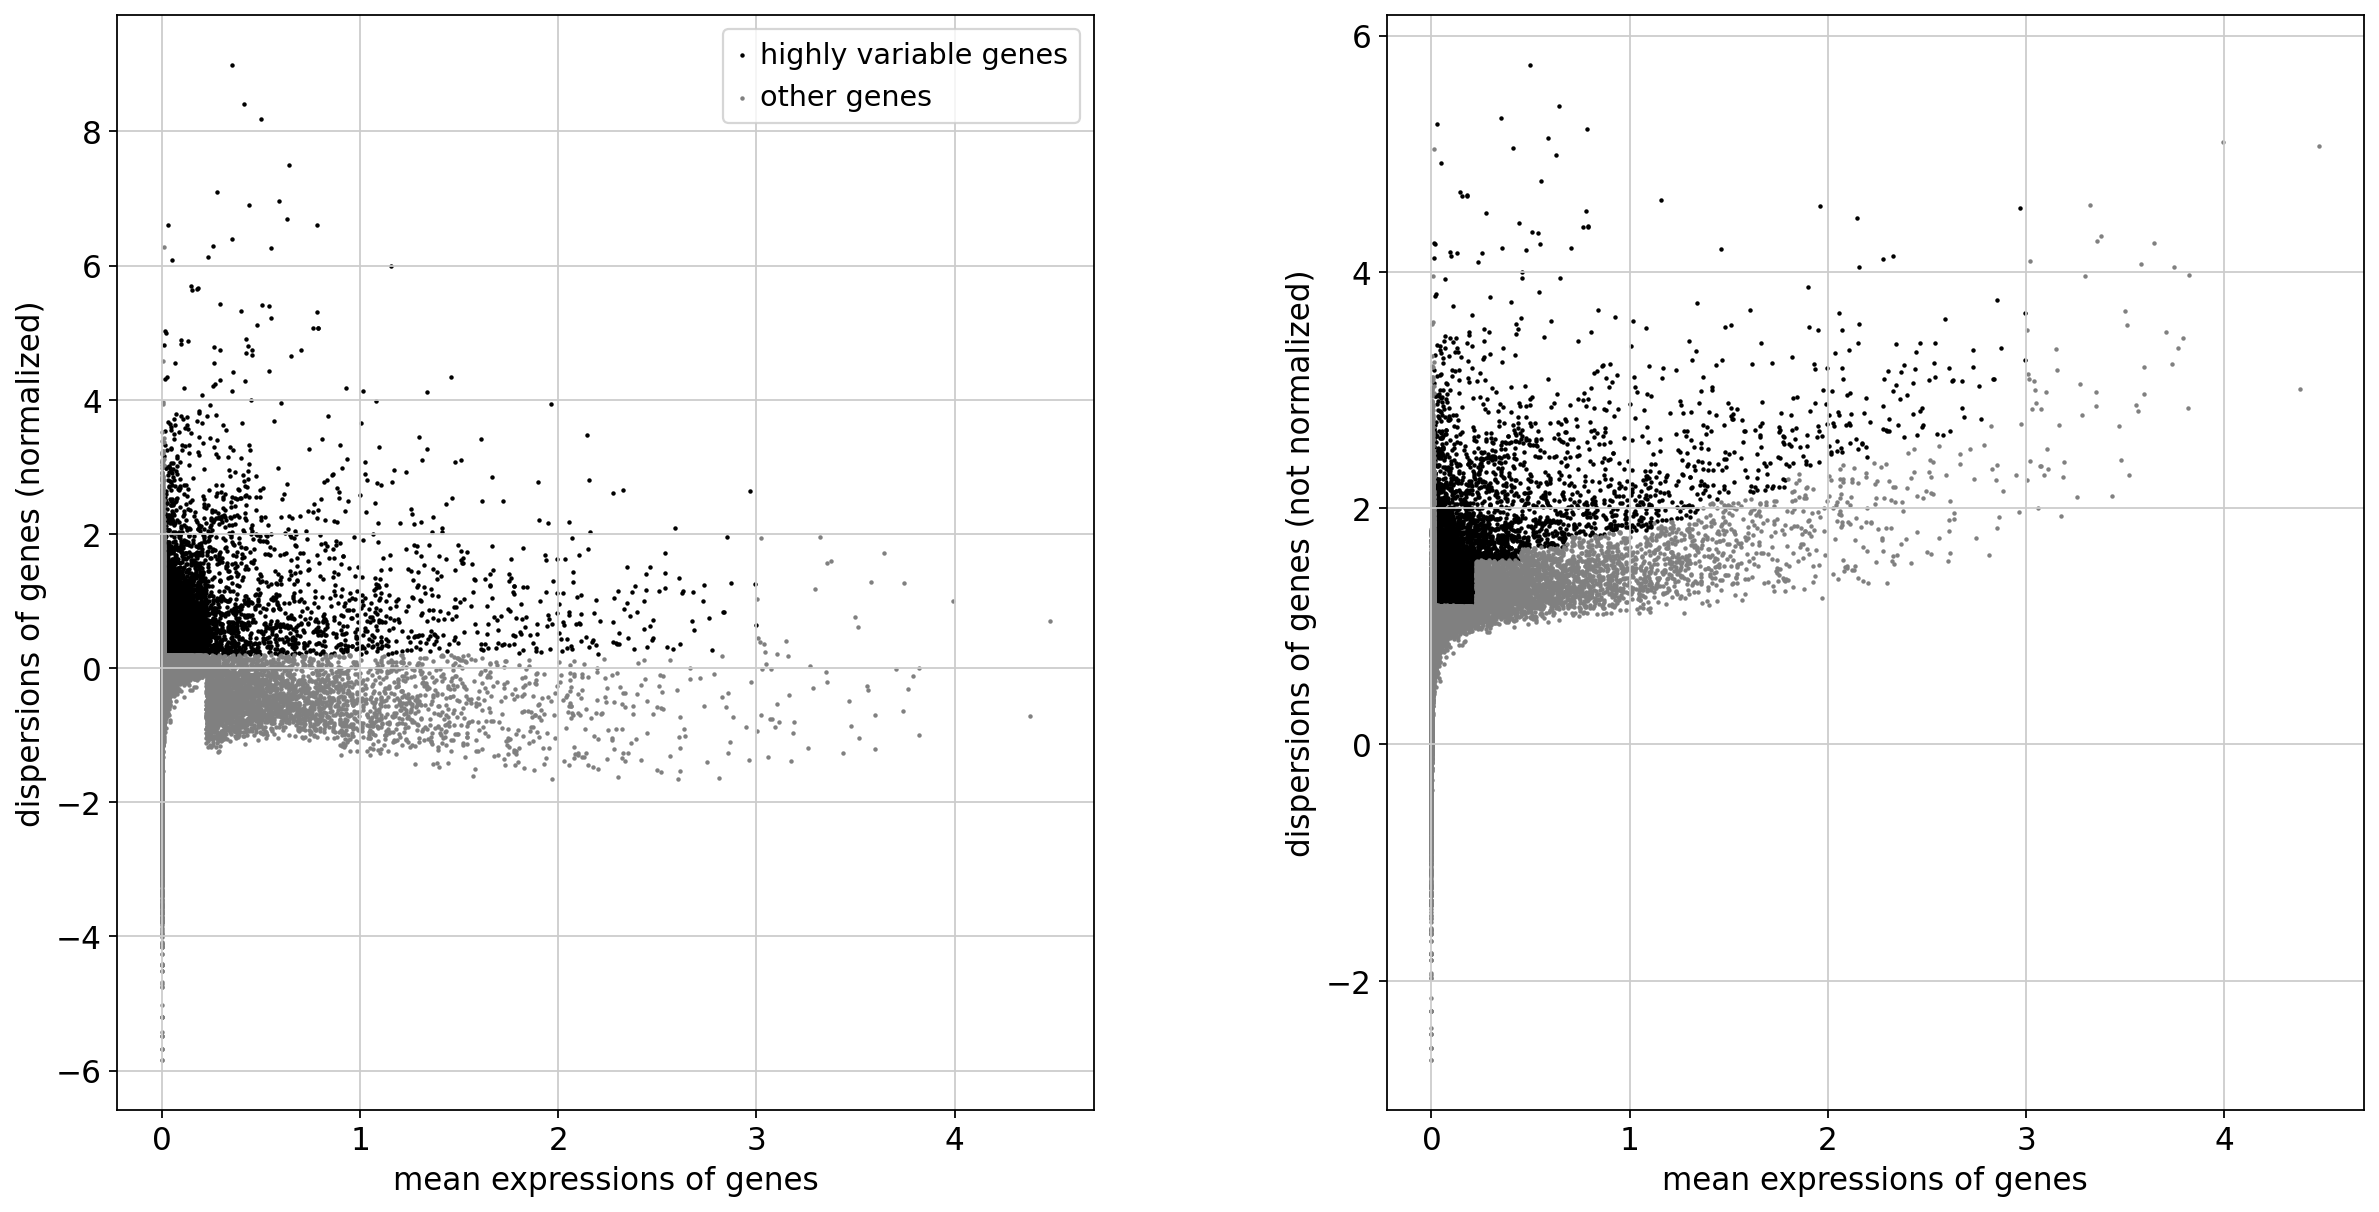

In [30]:
sc.pl.highly_variable_genes(rice_sc_data)


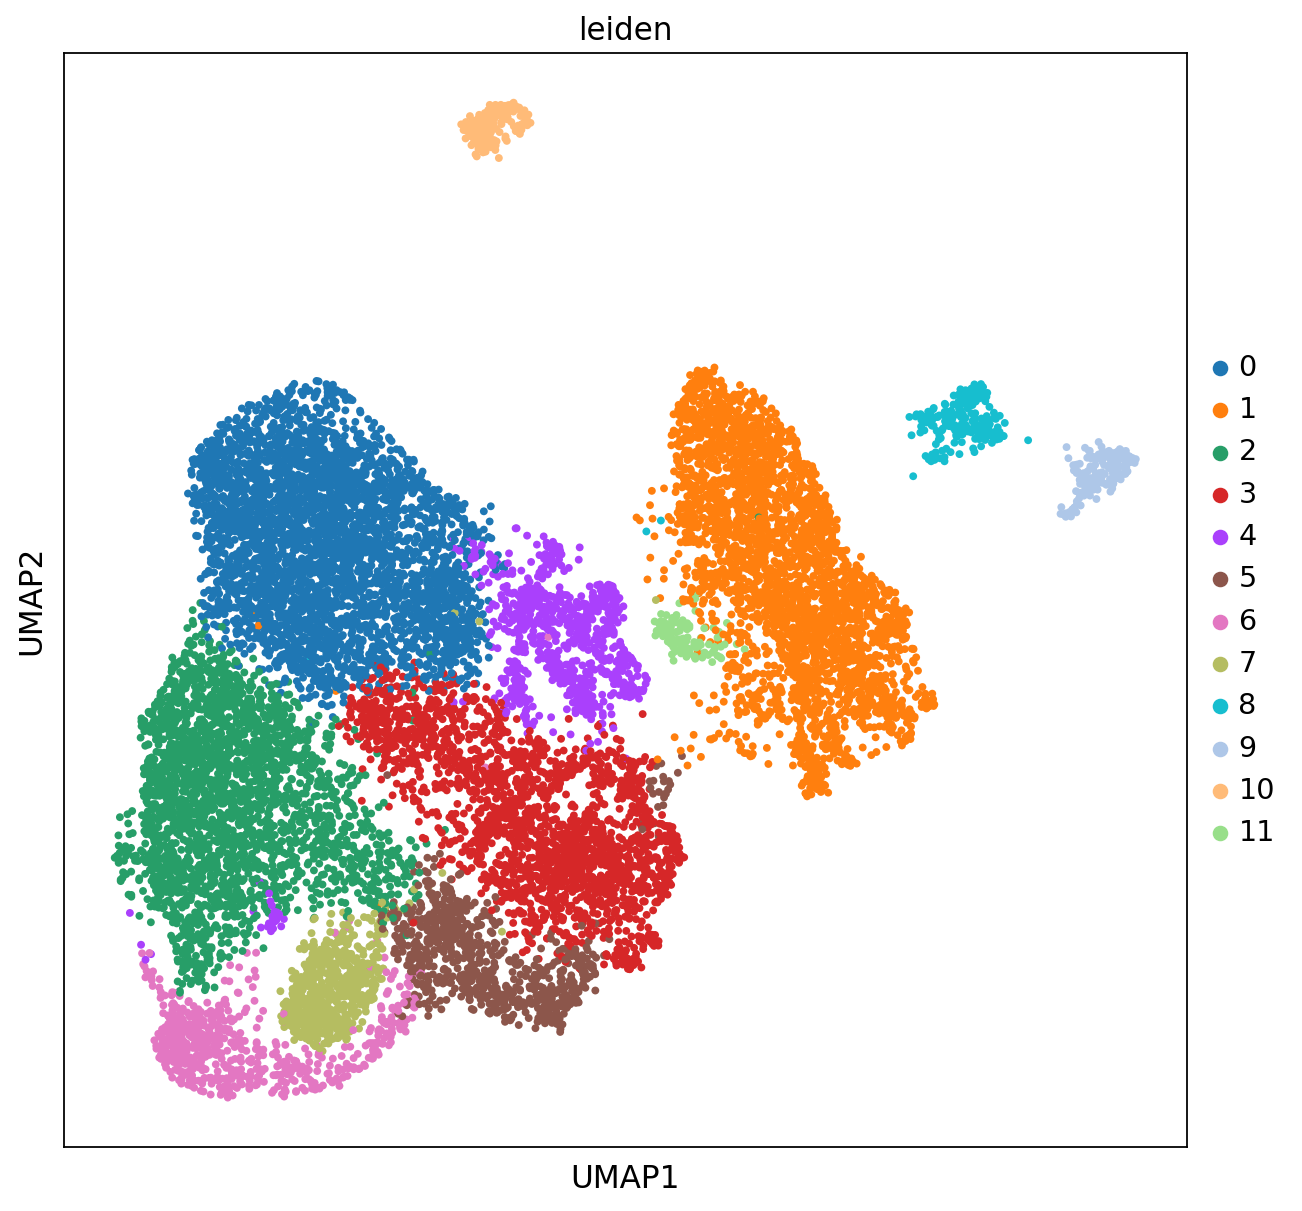

In [31]:
sc.tl.pca(rice_sc_data, svd_solver='arpack', random_state= 3456)
sc.pp.neighbors(rice_sc_data, n_neighbors=30, n_pcs=50, random_state= 112) ##30,50 # 25,45
sc.tl.umap(rice_sc_data, random_state= 649)
sc.tl.leiden(rice_sc_data, random_state= 823, resolution= .5)

sc.pl.umap(rice_sc_data, color = 'leiden', s=50,)

In [32]:
rice_sc_data

AnnData object with n_obs × n_vars = 14943 × 37863
    obs: 'leiden'
    var: 'gene_ids', 'feature_types', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [33]:
marker_genes = pd.read_csv('/home/passala/git/Coexpressalog_Method_Development/rice_maize_data/marker_genes.csv', sep= '\t')
#marker_genes['Gene ID'] =marker_genes['Gene ID'].str.split('-').str[1]
#marker_genes['Gene ID'] =marker_genes['Gene ID'].str[:5]+'0'+marker_genes['Gene ID'].str[5:]+'0'
marker_genes

Gene ID       P value  avg_log(Foldchange)  \
0     LOC-Os02g44310  0.000000e+00             1.648360   
1     LOC-Os06g13680  0.000000e+00             0.630611   
2     LOC-Os07g34589  0.000000e+00             0.597807   
3     LOC-Os01g21120  0.000000e+00             0.462817   
4     LOC-Os04g33110  0.000000e+00             0.756632   
...              ...           ...                  ...   
6536  LOC-Os05g19600  4.260000e-23             0.312931   
6537  LOC-Os03g26460  1.500000e-21             0.271316   
6538  LOC-Os06g35560  4.780000e-20             0.255126   
6539  LOC-Os01g52010  1.400000e-14             0.294384   
6540  LOC-Os09g26960  1.080000e-13             0.275655   

      pct.1 (enriched cluster)  pct.2 (other clusters)  adjusted P value  \
0                        0.999                   0.977      0.000000e+00   
1                        0.999                   0.998      0.000000e+00   
2                        0.999                   0.993      0.000000e+00   
3                        0.999                   0.991      0.000000e+00   
4                        0.996                   0.985      0.000000e+00   
...                        ...                     ...               ...   
6536                     0.176                   0.102      1.670000e-18   
6537                     0.433                   0.344      5.890000e-17   
6538                     0.600                   0.498      1.870000e-15   
6539                     0.302                   0.243      5.500000e-10   
6540                     0.345                   0.286      4.220000e-09   

     cluster  
0     cortex  
1     cortex  
2     cortex  
3     cortex  
4     cortex  
...      ...  
6536   stele  
6537   stele  
6538   stele  
6539   stele  
6540   stele  

[6541 rows x 7 columns]

In [34]:
gene_convertor_for_rice = pd.read_csv('/data/passala/Collaborator_Data/GEO_sourced_single_cell_for_CRUSH/Rice_japonica/genome_conversion/cleaned_conversion_with_duplicates.csv')


In [35]:
merged_marker_genes = marker_genes.merge(how = 'left', right= gene_convertor_for_rice, left_on= 'Gene ID', right_on= 'MSU Format',)
merged_marker_genes

Gene ID       P value  avg_log(Foldchange)  \
0     LOC-Os02g44310  0.000000e+00             1.648360   
1     LOC-Os06g13680  0.000000e+00             0.630611   
2     LOC-Os07g34589  0.000000e+00             0.597807   
3     LOC-Os01g21120  0.000000e+00             0.462817   
4     LOC-Os04g33110  0.000000e+00             0.756632   
...              ...           ...                  ...   
6612  LOC-Os05g19600  4.260000e-23             0.312931   
6613  LOC-Os03g26460  1.500000e-21             0.271316   
6614  LOC-Os06g35560  4.780000e-20             0.255126   
6615  LOC-Os01g52010  1.400000e-14             0.294384   
6616  LOC-Os09g26960  1.080000e-13             0.275655   

      pct.1 (enriched cluster)  pct.2 (other clusters)  adjusted P value  \
0                        0.999                   0.977      0.000000e+00   
1                        0.999                   0.998      0.000000e+00   
2                        0.999                   0.993      0.000000e+00   
3                        0.999                   0.991      0.000000e+00   
4                        0.996                   0.985      0.000000e+00   
...                        ...                     ...               ...   
6612                     0.176                   0.102      1.670000e-18   
6613                     0.433                   0.344      5.890000e-17   
6614                     0.600                   0.498      1.870000e-15   
6615                     0.302                   0.243      5.500000e-10   
6616                     0.345                   0.286      4.220000e-09   

     cluster    RAP Format      MSU Format  
0     cortex  Os02g0662000  LOC-Os02g44310  
1     cortex  Os06g0246000  LOC-Os06g13680  
2     cortex  Os07g0529800  LOC-Os07g34589  
3     cortex  Os01g0313300  LOC-Os01g21120  
4     cortex  Os04g0403900  LOC-Os04g33110  
...      ...           ...             ...  
6612   stele  Os05g0277000  LOC-Os05g19600  
6613   stele  Os03g0381300  LOC-Os03g26460  
6614   stele  Os06g0548200  LOC-Os06g35560  
6615   stele  Os01g0717700  LOC-Os01g52010  
6616   stele  Os09g0441400  LOC-Os09g26960  

[6617 rows x 9 columns]

In [36]:
rice_sc_data.var_names_make_unique()

In [37]:
merged_marker_genes.loc[merged_marker_genes['Gene ID'].isin(['LOC-Os05g39960'])]

Gene ID        P value  avg_log(Foldchange)  \
920  LOC-Os05g39960  8.070000e-256             2.804204   

     pct.1 (enriched cluster)  pct.2 (other clusters)  adjusted P value  \
920                       1.0                   0.306     3.160000e-251   

        cluster    RAP Format      MSU Format  
920  endodermis  Os05g0477300  LOC-Os05g39960

In [38]:
merged_marker_genes.loc[merged_marker_genes['RAP Format'].isin(rice_sc_data.var.index)].loc[merged_marker_genes['cluster']=='stele'].head(20)

Gene ID  P value  avg_log(Foldchange)  pct.1 (enriched cluster)  \
5981  LOC-Os01g18170      0.0             1.302331                     1.000   
5982  LOC-Os07g03279      0.0             0.787610                     1.000   
5983  LOC-Os01g25560      0.0             0.664794                     0.999   
5984  LOC-Os04g56100      0.0             0.624333                     0.998   
5985  LOC-Os04g47220      0.0             0.674268                     0.997   
5986  LOC-Os10g30790      0.0             0.590438                     0.996   
5987  LOC-Os11g42960      0.0             1.612527                     0.994   
5988  LOC-Os03g13140      0.0             0.911512                     0.992   
5989  LOC-Os10g28050      0.0             0.713794                     0.992   
5990  LOC-Os03g51080      0.0             0.492899                     0.992   
5991  LOC-Os01g03340      0.0             0.844496                     0.991   
5992  LOC-Os03g09900      0.0             0.593086                     0.991   
5993  LOC-Os06g46799      0.0             2.747570                     0.987   
5994  LOC-Os08g06100      0.0             0.525474                     0.985   
5995  LOC-Os07g07790      0.0             2.805350                     0.983   
5996  LOC-Os01g15830      0.0             2.742166                     0.982   
5997  LOC-Os02g33080      0.0             0.642733                     0.980   
5998  LOC-Os01g18744      0.0             0.680905                     0.978   
5999  LOC-Os10g28200      0.0             0.819171                     0.970   
6000  LOC-Os02g40840      0.0             0.729416                     0.965   

      pct.2 (other clusters)  adjusted P value cluster    RAP Format  \
5981                   0.966               0.0   stele  Os01g0284500   
5982                   0.996               0.0   stele  Os07g0124900   
5983                   0.966               0.0   stele  Os01g0358100   
5984                   0.974               0.0   stele  Os04g0655100   
5985                   0.968               0.0   stele  Os04g0559700   
5986                   0.911               0.0   stele  Os10g0444700   
5987                   0.430               0.0   stele  Os11g0649600   
5988                   0.827               0.0   stele  Os03g0233900   
5989                   0.779               0.0   stele  Os10g0416100   
5990                   0.930               0.0   stele  Os03g0720300   
5991                   0.854               0.0   stele  Os01g0124200   
5992                   0.891               0.0   stele  Os03g0194900   
5993                   0.426               0.0   stele  Os06g0681600   
5994                   0.801               0.0   stele  Os08g0157500   
5995                   0.160               0.0   stele  Os07g0174400   
5996                   0.413               0.0   stele  Os01g0263300   
5997                   0.894               0.0   stele  Os02g0533900   
5998                   0.600               0.0   stele  Os01g0291500   
5999                   0.820               0.0   stele  Os10g0417600   
6000                   0.753               0.0   stele  Os02g0621800   

          MSU Format  
5981  LOC-Os01g18170  
5982  LOC-Os07g03279  
5983  LOC-Os01g25560  
5984  LOC-Os04g56100  
5985  LOC-Os04g47220  
5986  LOC-Os10g30790  
5987  LOC-Os11g42960  
5988  LOC-Os03g13140  
5989  LOC-Os10g28050  
5990  LOC-Os03g51080  
5991  LOC-Os01g03340  
5992  LOC-Os03g09900  
5993  LOC-Os06g46799  
5994  LOC-Os08g06100  
5995  LOC-Os07g07790  
5996  LOC-Os01g15830  
5997  LOC-Os02g33080  
5998  LOC-Os01g18744  
5999  LOC-Os10g28200  
6000  LOC-Os02g40840

In [39]:
#sc.pl.umap(rice_sc_data, color = ['leiden','Os05g0477300'], s=50, legend_loc = 'on data')# endodermis

In [40]:
#sc.pl.umap(rice_sc_data, color = ['leiden','Os03g0223400'], s=50, legend_loc = 'on data')# epi near root hair

In [41]:
#sc.pl.umap(rice_sc_data, color = ['leiden','Os05g0246300'], s=50, legend_loc = 'on data')# root cap

In [42]:
#sc.pl.umap(rice_sc_data, color = ['leiden','Os07g0104100'], s=50, legend_loc = 'on data')# metaxylem

In [43]:
#sc.pl.umap(rice_sc_data, color = ['leiden','Os07g0174900'], s=50, legend_loc = 'on data')# stele

In [44]:
#sc.pl.umap(rice_sc_data, color = ['leiden','Os06g0335900'], s=50, legend_loc = 'on data') ## root hair

In [45]:
#sc.pl.umap(rice_sc_data, color = ['leiden','Os07g0529800'], s=50, legend_loc = 'on data') # cortex

In [46]:
#sc.pl.umap(rice_sc_data, color = ['leiden','Os12g0548401'], s=50, legend_loc = 'on data') # cortex

In [47]:
#sc.pl.umap(rice_sc_data, color = ['leiden','Os01g0282800'], s=50, legend_loc = 'on data') ## epidermiks

In [48]:
#sc.pl.umap(rice_sc_data, color = ['leiden','Os01g72340'], s=50, legend_loc = 'on data') # cortex

In [49]:
rice_sc_data.var

gene_ids    feature_types  highly_variable         means  \
Os01g0100100  Os01g0100100  Gene Expression            False  9.381453e-03   
Os01g0100200  Os01g0100200  Gene Expression            False  4.067292e-02   
Os01g0100300  Os01g0100300  Gene Expression            False  4.735694e-04   
Os01g0100400  Os01g0100400  Gene Expression            False  4.003630e-03   
Os01g0100466  Os01g0100466  Gene Expression            False  1.000000e-12   
...                    ...              ...              ...           ...   
Os12g0641200  Os12g0641200  Gene Expression            False  1.339003e-02   
Os12g0641300  Os12g0641300  Gene Expression            False  1.637107e-02   
Os12g0641400  Os12g0641400  Gene Expression             True  4.142963e-01   
Os12g0641500  Os12g0641500  Gene Expression             True  6.777357e-02   
Os12g0641600  Os12g0641600  Gene Expression            False  1.000000e-12   

              dispersions  dispersions_norm  
Os01g0100100     1.401757          0.553759  
Os01g0100200     0.994555         -0.085596  
Os01g0100300     0.386184         -1.040810  
Os01g0100400     0.607636         -0.693104  
Os01g0100466          NaN          0.000000  
...                   ...               ...  
Os12g0641200     0.937923         -0.174515  
Os12g0641300     0.751851         -0.466670  
Os12g0641400     1.574961          0.228052  
Os12g0641500     1.372489          0.507805  
Os12g0641600          NaN          0.000000  

[37863 rows x 6 columns]

In [50]:
rice_sc_data.obs

leiden
AAACCTGAGCACCGTC-1      4
AAACCTGAGCTTTGGT-1      0
AAACCTGAGGCTACGA-1      0
AAACCTGAGTAAGTAC-1      8
AAACCTGAGTAGTGCG-1      1
...                   ...
TTTGTCATCATTGCCC-1      3
TTTGTCATCCCTTGTG-1      0
TTTGTCATCGGCGGTT-1     10
TTTGTCATCGGTCCGA-1      1
TTTGTCATCTATCCCG-1      1

[14943 rows x 1 columns]

In [51]:
rice_sc_data.obs['Cell Cluster Annotation'] = 'Not Annotated'
rice_sc_data.obs['Cell Cluster Annotation'].loc[rice_sc_data.obs['leiden'].isin(['1','11'])] = 'Stele'
rice_sc_data.obs['Cell Cluster Annotation'].loc[rice_sc_data.obs['leiden'].isin(['0','3',])] = 'Cortex'
rice_sc_data.obs['Cell Cluster Annotation'].loc[rice_sc_data.obs['leiden'].isin(['2','5','6'])] = 'Epidermis'
rice_sc_data.obs['Cell Cluster Annotation'].loc[rice_sc_data.obs['leiden'].isin(['9'])] = 'Root Hair'

types_to_include_in_mapping = ['Epidermis','Cortex','Stele', 'Root Hair']

/tmp/ipykernel_2457097/2794517125.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rice_sc_data.obs['Cell Cluster Annotation'].loc[rice_sc_data.obs['leiden'].isin(['1','11'])] = 'Stele'
/tmp/ipykernel_2457097/2794517125.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rice_sc_data.obs['Cell Cluster Annotation'].loc[rice_sc_data.obs['leiden'].isin(['0','3',])] = 'Cortex'
/tmp/ipykernel_2457097/2794517125.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returni

In [52]:
sec_rice = rice_sc_data[rice_sc_data.obs.loc[rice_sc_data.obs['Cell Cluster Annotation'].isin(types_to_include_in_mapping)].index,:]
sec_rice

View of AnnData object with n_obs × n_vars = 13077 × 37863
    obs: 'leiden', 'Cell Cluster Annotation'
    var: 'gene_ids', 'feature_types', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

/home/passala/miniconda3/envs/Single_cell_data_fix/lib/python3.9/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


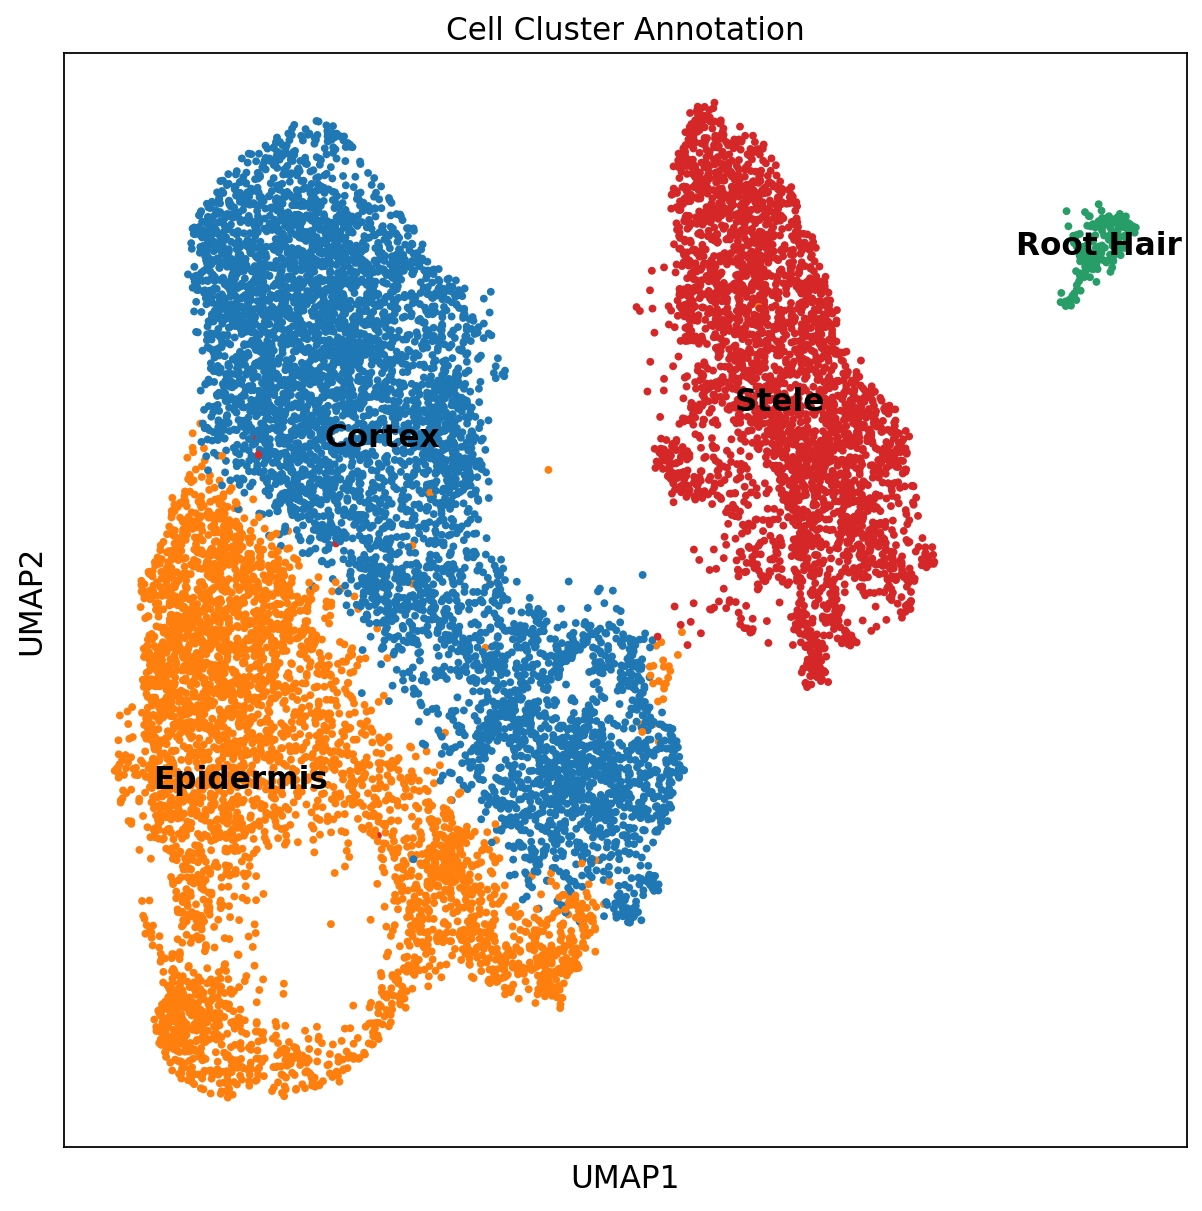

In [53]:
sc.pl.umap(sec_rice, color = ['Cell Cluster Annotation'], s=50, legend_loc = 'on data')

In [54]:
sec_maize = maize_Data[maize_Data.obs.loc[maize_Data.obs['Cell Cluster Annotation'].isin(types_to_include_in_mapping)].index,:]


In [55]:
sec_maize.obs.value_counts(subset = 'Cell Cluster Annotation')

Cell Cluster Annotation
Cortex       1719
Stele         677
Epidermis     329
Root Hair     107
dtype: int64

/home/passala/miniconda3/envs/Single_cell_data_fix/lib/python3.9/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


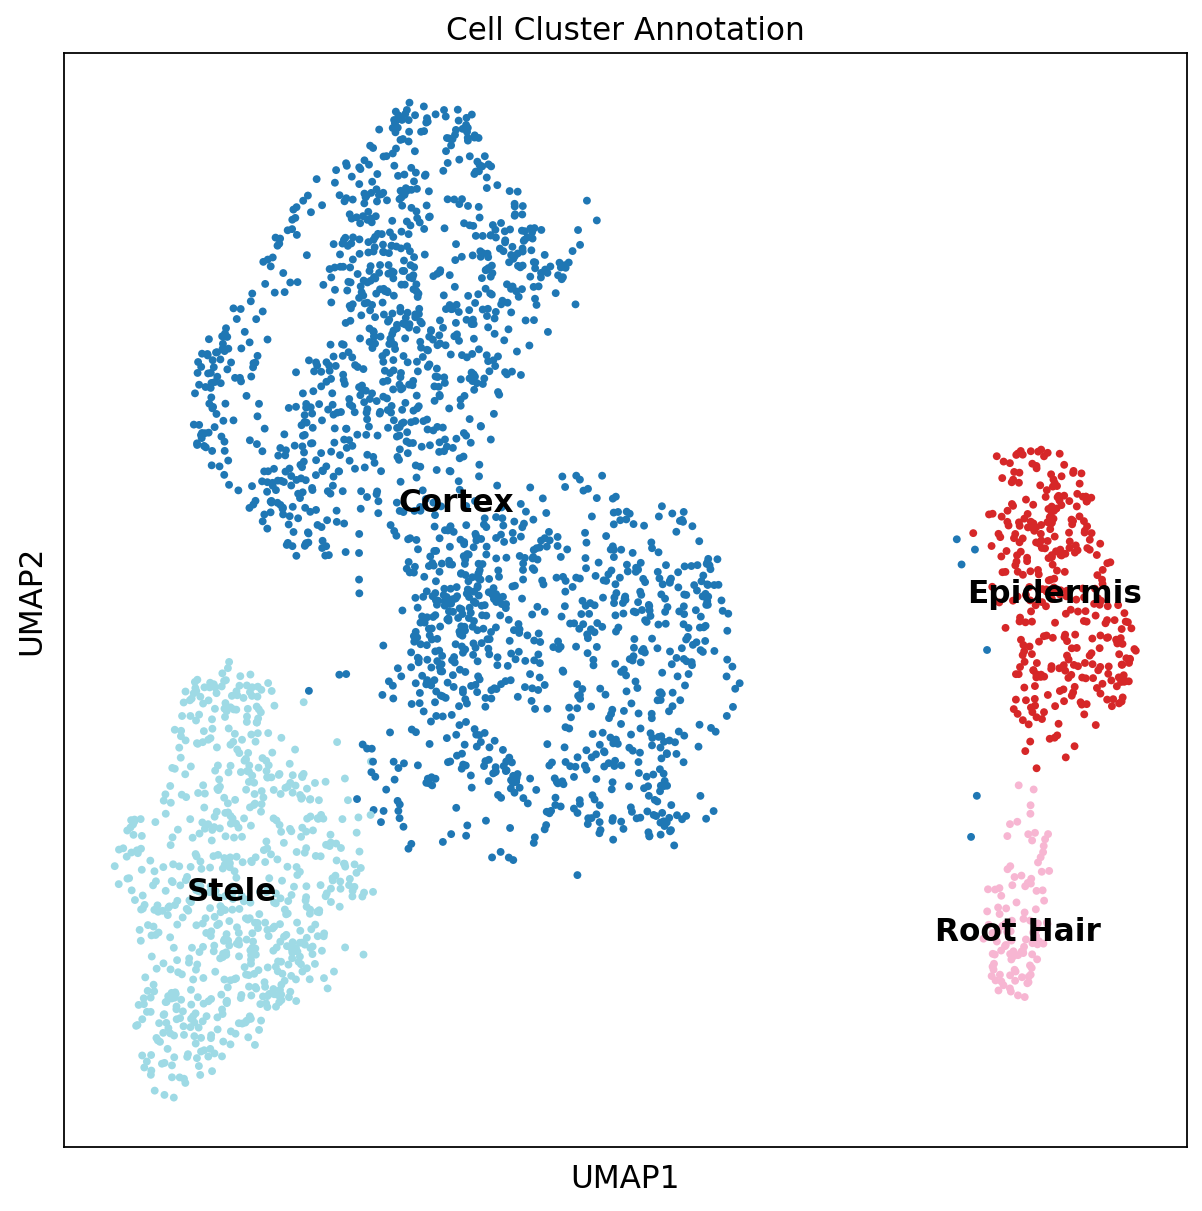

In [56]:
sc.pl.umap(sec_maize, color = ['Cell Cluster Annotation'],palette= 'tab20', s=50, legend_loc = 'on data')

In [57]:
sec_rice.var['Gene Name'] = sec_rice.var.index
sec_rice.var = sec_rice.var.rename(columns = {'Gene Name':'Gene ID'})
sec_rice.var = sec_rice.var.merge(right = co_expressalog_map_85, right_on = 'Rice Gene', how = 'left', left_on= 'Gene ID')
sec_rice.var

/home/passala/miniconda3/envs/Single_cell_data_fix/lib/python3.9/site-packages/anndata/_core/anndata.py:798: UserWarning: 
AnnData expects .var.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  value_idx = self._prep_dim_index(value.index, attr)


gene_ids    feature_types  highly_variable         means  \
0      Os01g0100100  Gene Expression            False  9.381453e-03   
1      Os01g0100200  Gene Expression            False  4.067292e-02   
2      Os01g0100300  Gene Expression            False  4.735694e-04   
3      Os01g0100400  Gene Expression            False  4.003630e-03   
4      Os01g0100466  Gene Expression            False  1.000000e-12   
...             ...              ...              ...           ...   
37858  Os12g0641200  Gene Expression            False  1.339003e-02   
37859  Os12g0641300  Gene Expression            False  1.637107e-02   
37860  Os12g0641400  Gene Expression             True  4.142963e-01   
37861  Os12g0641500  Gene Expression             True  6.777357e-02   
37862  Os12g0641600  Gene Expression            False  1.000000e-12   

       dispersions  dispersions_norm       Gene ID      Maize Gene  \
0         1.401757          0.553759  Os01g0100100  Zm00001d040234   
1         0.994555         -0.085596  Os01g0100200             NaN   
2         0.386184         -1.040810  Os01g0100300             NaN   
3         0.607636         -0.693104  Os01g0100400             NaN   
4              NaN          0.000000  Os01g0100466             NaN   
...            ...               ...           ...             ...   
37858     0.937923         -0.174515  Os12g0641200             NaN   
37859     0.751851         -0.466670  Os12g0641300  Zm00001d041191   
37860     1.574961          0.228052  Os12g0641400    LOC100240688   
37861     1.372489          0.507805  Os12g0641500             NaN   
37862          NaN          0.000000  Os12g0641600             NaN   

          Rice Gene  
0      Os01g0100100  
1               NaN  
2               NaN  
3               NaN  
4               NaN  
...             ...  
37858           NaN  
37859  Os12g0641300  
37860  Os12g0641400  
37861           NaN  
37862           NaN  

[37863 rows x 9 columns]

In [58]:
sec_rice.var = sec_rice.var.set_index('Gene ID')
sec_rice.var

gene_ids    feature_types  highly_variable         means  \
Gene ID                                                                      
Os01g0100100  Os01g0100100  Gene Expression            False  9.381453e-03   
Os01g0100200  Os01g0100200  Gene Expression            False  4.067292e-02   
Os01g0100300  Os01g0100300  Gene Expression            False  4.735694e-04   
Os01g0100400  Os01g0100400  Gene Expression            False  4.003630e-03   
Os01g0100466  Os01g0100466  Gene Expression            False  1.000000e-12   
...                    ...              ...              ...           ...   
Os12g0641200  Os12g0641200  Gene Expression            False  1.339003e-02   
Os12g0641300  Os12g0641300  Gene Expression            False  1.637107e-02   
Os12g0641400  Os12g0641400  Gene Expression             True  4.142963e-01   
Os12g0641500  Os12g0641500  Gene Expression             True  6.777357e-02   
Os12g0641600  Os12g0641600  Gene Expression            False  1.000000e-12   

              dispersions  dispersions_norm      Maize Gene     Rice Gene  
Gene ID                                                                    
Os01g0100100     1.401757          0.553759  Zm00001d040234  Os01g0100100  
Os01g0100200     0.994555         -0.085596             NaN           NaN  
Os01g0100300     0.386184         -1.040810             NaN           NaN  
Os01g0100400     0.607636         -0.693104             NaN           NaN  
Os01g0100466          NaN          0.000000             NaN           NaN  
...                   ...               ...             ...           ...  
Os12g0641200     0.937923         -0.174515             NaN           NaN  
Os12g0641300     0.751851         -0.466670  Zm00001d041191  Os12g0641300  
Os12g0641400     1.574961          0.228052    LOC100240688  Os12g0641400  
Os12g0641500     1.372489          0.507805             NaN           NaN  
Os12g0641600          NaN          0.000000             NaN           NaN  

[37863 rows x 8 columns]

In [59]:
sec_maize.var = sec_maize.var.merge(right = co_expressalog_map_85, how = 'left', right_on= 'Maize Gene', left_on='gene_ids')
sec_maize.var

/home/passala/miniconda3/envs/Single_cell_data_fix/lib/python3.9/site-packages/anndata/_core/anndata.py:798: UserWarning: 
AnnData expects .var.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  value_idx = self._prep_dim_index(value.index, attr)


gene_ids    feature_types  In CoCoCoNet  n_cells  \
0       Zm00001d027230  Gene Expression             0       67   
1       Zm00001d027231  Gene Expression             1      290   
2       Zm00001d027233  Gene Expression             1        2   
3       Zm00001d027236  Gene Expression             1       36   
4       Zm00001d027239  Gene Expression             1       60   
...                ...              ...           ...      ...   
25648  ENSRNA049478534  Gene Expression             1       67   
25649  ENSRNA049478548  Gene Expression             0        8   
25650  ENSRNA049478530  Gene Expression             1      217   
25651   Zm00001d000458  Gene Expression             0        2   
25652   Zm00001d000460  Gene Expression             0        4   

       highly_variable     means  dispersions  dispersions_norm Maize Gene  \
0                False  0.024387     1.696221         -0.095275        NaN   
1                 True  0.241811     2.104409          0.435565        NaN   
2                False  0.000593     0.203313         -2.036773        NaN   
3                 True  0.021745     2.032777          0.342410        NaN   
4                False  0.023626     1.419417         -0.455253        NaN   
...                ...       ...          ...               ...        ...   
25648             True  0.090445     2.502171          0.952848        NaN   
25649            False  0.010975     2.160190          0.508108        NaN   
25650             True  0.307557     2.541439          1.507421        NaN   
25651            False  0.000167    -0.994376         -3.594344        NaN   
25652            False  0.001130     0.942761         -1.075135        NaN   

      Rice Gene  
0           NaN  
1           NaN  
2           NaN  
3           NaN  
4           NaN  
...         ...  
25648       NaN  
25649       NaN  
25650       NaN  
25651       NaN  
25652       NaN  

[25653 rows x 10 columns]

In [60]:
sec_maize.obs.value_counts(subset = 'Cell Cluster Annotation')

Cell Cluster Annotation
Cortex       1719
Stele         677
Epidermis     329
Root Hair     107
dtype: int64

In [61]:
rice_var_names_with_ortholog = sec_rice.var.dropna().index
rice_version_of_maize_genes_with_ortholog = sec_maize.var.dropna()['Rice Gene'].to_list()

rice_var_names_with_ortholog
overlap_of_shared_genes = rice_var_names_with_ortholog.intersection(rice_version_of_maize_genes_with_ortholog)

maize_genes_to_keep = sec_maize.var.loc[sec_maize.var['Rice Gene'].isin(overlap_of_shared_genes)].index

In [62]:
sec_maize.var = sec_maize.var.set_index('gene_ids')


In [63]:
sec_maize

AnnData object with n_obs × n_vars = 2832 × 25653
    obs: 'n_genes', 'leiden', 'Cell Cluster Annotation'
    var: 'feature_types', 'In CoCoCoNet', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'Maize Gene', 'Rice Gene'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors', 'Cell Cluster Annotation_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [64]:
maize_single_cell_trimmed_to_orthologs = sec_maize[:,maize_genes_to_keep]
maize_single_cell_trimmed_to_orthologs

View of AnnData object with n_obs × n_vars = 2832 × 1909
    obs: 'n_genes', 'leiden', 'Cell Cluster Annotation'
    var: 'feature_types', 'In CoCoCoNet', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'Maize Gene', 'Rice Gene'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors', 'Cell Cluster Annotation_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [65]:
rice_genes_to_keep = sec_rice.var.loc[sec_rice.var['Rice Gene'].isin(overlap_of_shared_genes)].index

In [66]:
rice_genes_to_keep

Index(['Os01g0100100', 'Os01g0102600', 'Os01g0103100', 'Os01g0104000',
       'Os01g0106500', 'Os01g0108600', 'Os01g0110700', 'Os01g0111700',
       'Os01g0118400', 'Os01g0120500',
       ...
       'Os12g0604800', 'Os12g0605800', 'Os12g0609800', 'Os12g0610800',
       'Os12g0613500', 'Os12g0621700', 'Os12g0623600', 'Os12g0631200',
       'Os12g0638800', 'Os12g0641100'],
      dtype='object', name='Gene ID', length=1909)

In [67]:
rice_single_cell_slimmed_to_orthologs = sec_rice[:,rice_genes_to_keep]
rice_single_cell_slimmed_to_orthologs

View of AnnData object with n_obs × n_vars = 13077 × 1909
    obs: 'leiden', 'Cell Cluster Annotation'
    var: 'gene_ids', 'feature_types', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'Maize Gene', 'Rice Gene'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors', 'Cell Cluster Annotation_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [68]:
maize_single_cell_trimmed_to_orthologs.var.index = maize_single_cell_trimmed_to_orthologs.var['Rice Gene'].to_list()
maize_single_cell_trimmed_to_orthologs.var

feature_types  In CoCoCoNet  n_cells  highly_variable  \
Os10g0561100  Gene Expression             1      149             True   
Os03g0102500  Gene Expression             1      123             True   
Os08g0243100  Gene Expression             1       65             True   
Os03g0110300  Gene Expression             1     1387            False   
Os03g0110400  Gene Expression             1      175             True   
...                       ...           ...      ...              ...   
Os02g0699900  Gene Expression             1        5            False   
Os06g0144800  Gene Expression             1       26            False   
Os01g0880900  Gene Expression             1        8            False   
Os05g0510200  Gene Expression             1       37            False   
Os02g0732200  Gene Expression             1      243             True   

                 means  dispersions  dispersions_norm      Maize Gene  \
Os10g0561100  0.119988     2.328042          0.726396  Zm00001d027276   
Os03g0102500  0.098402     2.094270          0.422380  Zm00001d027281   
Os08g0243100  0.056373     2.152823          0.498527  Zm00001d027319   
Os03g0110300  1.112336     2.310547         -0.372954  Zm00001d027323   
Os03g0110400  0.134171     2.278004          0.661323  Zm00001d027324   
...                ...          ...               ...             ...   
Os02g0699900  0.003530     2.495768          0.944520  Zm00001d000165   
Os06g0144800  0.012398     1.805175          0.046417  Zm00001d000213   
Os01g0880900  0.001004     0.538321         -1.601101  Zm00001d000220   
Os05g0510200  0.010846     1.102488         -0.867413  Zm00001d000311   
Os02g0732200  0.295794     2.408281          0.955953  Zm00001d000381   

                 Rice Gene  
Os10g0561100  Os10g0561100  
Os03g0102500  Os03g0102500  
Os08g0243100  Os08g0243100  
Os03g0110300  Os03g0110300  
Os03g0110400  Os03g0110400  
...                    ...  
Os02g0699900  Os02g0699900  
Os06g0144800  Os06g0144800  
Os01g0880900  Os01g0880900  
Os05g0510200  Os05g0510200  
Os02g0732200  Os02g0732200  

[1909 rows x 9 columns]

In [69]:
order_of_vars = rice_single_cell_slimmed_to_orthologs.var.index.to_list()
current_order_maize_vars = maize_single_cell_trimmed_to_orthologs.var_names
panda_version_of_maize_x_data = pd.DataFrame(columns = current_order_maize_vars, data = maize_single_cell_trimmed_to_orthologs.X.todense())
re_ordered_version = panda_version_of_maize_x_data.reindex(columns = order_of_vars)
re_ordered_version = sparse.csr_matrix(re_ordered_version.values)
maize_single_cell_trimmed_to_orthologs.X = re_ordered_version
maize_single_cell_trimmed_to_orthologs.var = maize_single_cell_trimmed_to_orthologs.var.reindex(order_of_vars)

/home/passala/miniconda3/envs/Single_cell_data_fix/lib/python3.9/site-packages/scipy/sparse/_index.py:137: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)


In [70]:
rice_single_cell_slimmed_to_orthologs.obs

leiden Cell Cluster Annotation
AAACCTGAGCTTTGGT-1      0                  Cortex
AAACCTGAGGCTACGA-1      0                  Cortex
AAACCTGAGTAGTGCG-1      1                   Stele
AAACCTGAGTGTACGG-1      6               Epidermis
AAACCTGCAACTTGAC-1      1                   Stele
...                   ...                     ...
TTTGTCATCAAACCAC-1      6               Epidermis
TTTGTCATCATTGCCC-1      3                  Cortex
TTTGTCATCCCTTGTG-1      0                  Cortex
TTTGTCATCGGTCCGA-1      1                   Stele
TTTGTCATCTATCCCG-1      1                   Stele

[13077 rows x 2 columns]

/home/passala/miniconda3/envs/Single_cell_data_fix/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


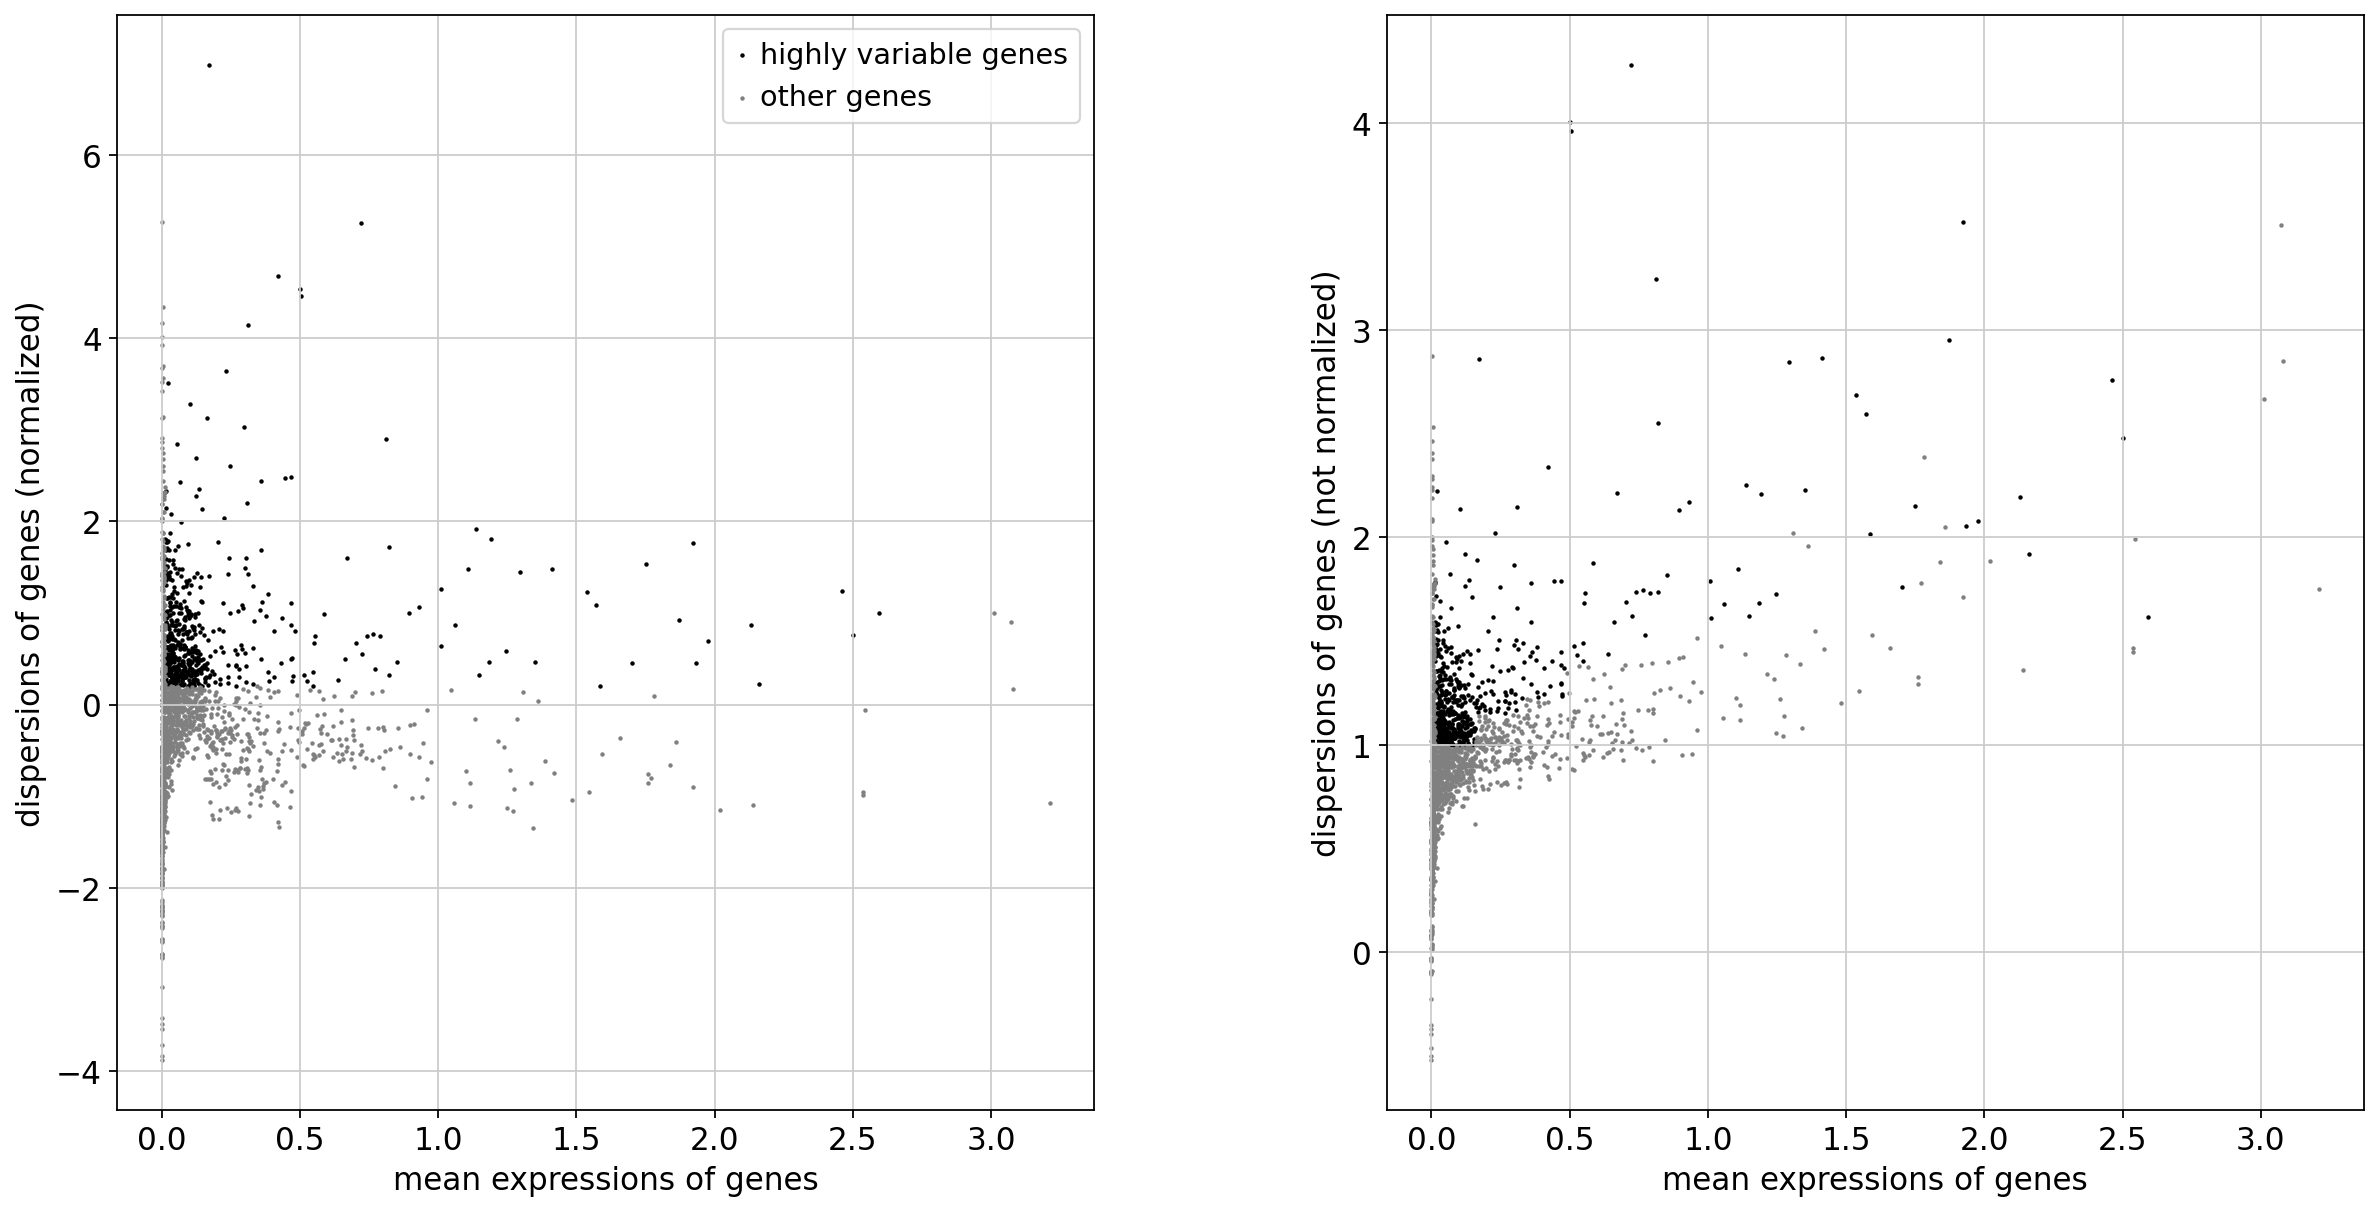

In [71]:
sc.pp.highly_variable_genes(rice_single_cell_slimmed_to_orthologs, min_mean=0.0125, max_mean=3, min_disp=.2)
sc.pl.highly_variable_genes(rice_single_cell_slimmed_to_orthologs)

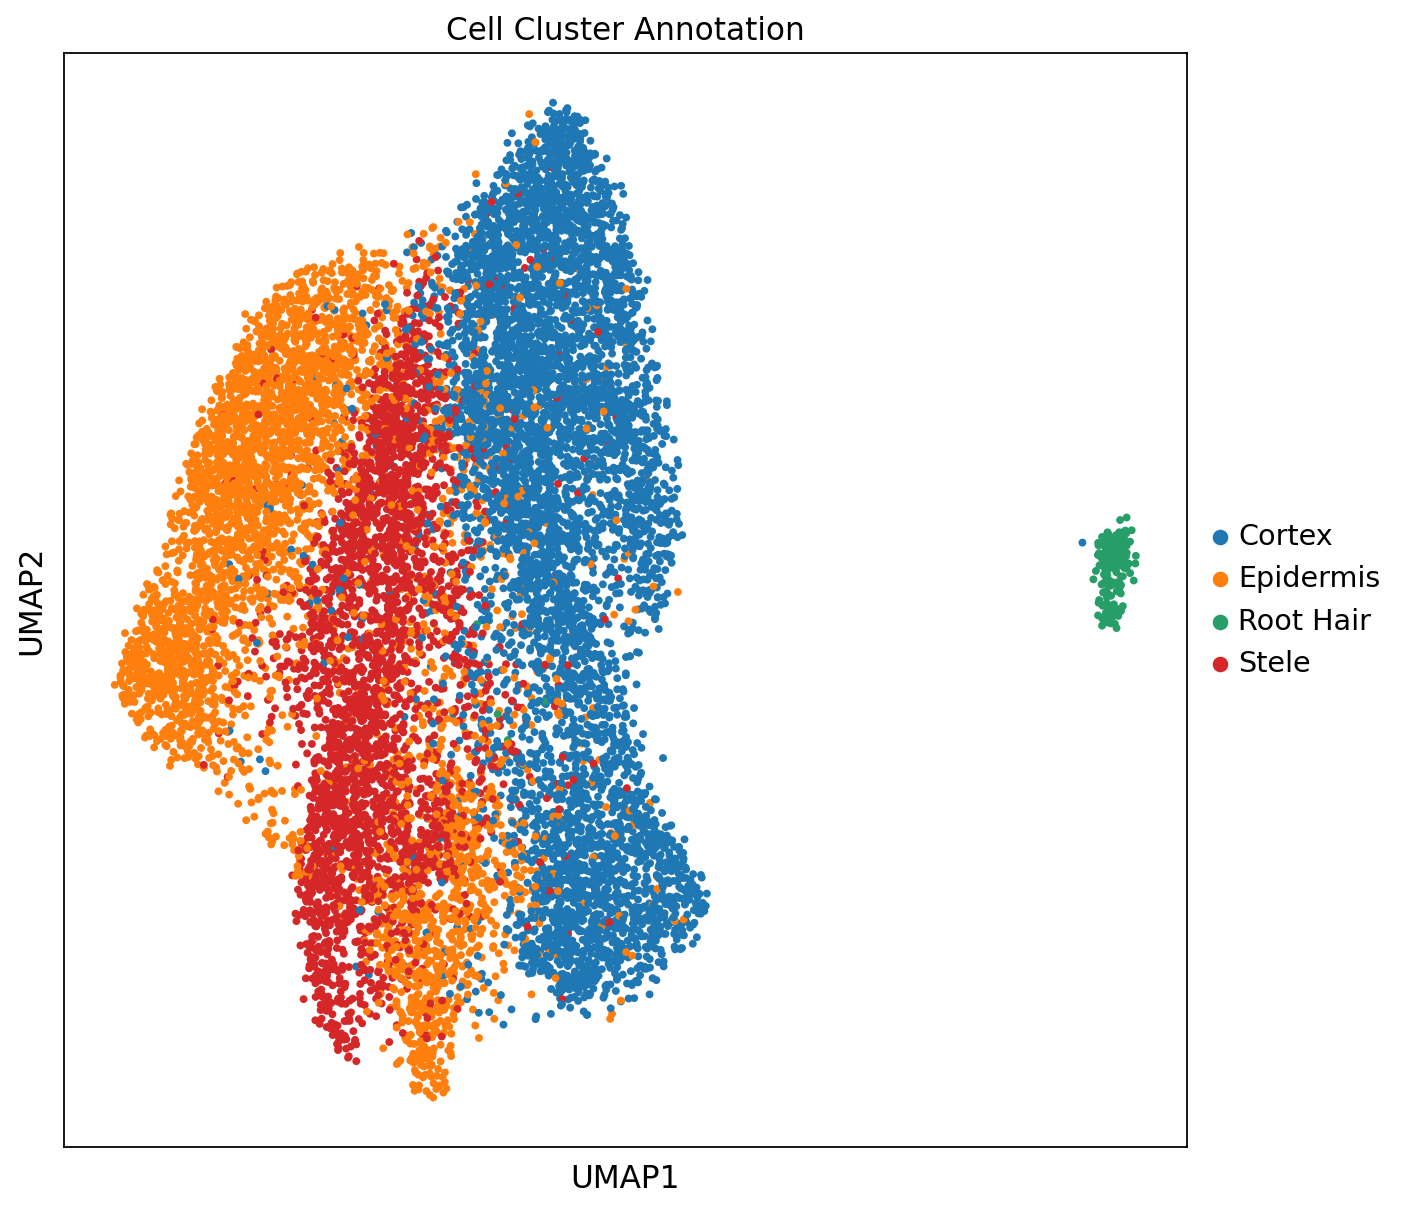

In [72]:
sc.tl.pca(rice_single_cell_slimmed_to_orthologs, svd_solver='arpack', random_state= 5463)
sc.pp.neighbors(rice_single_cell_slimmed_to_orthologs, n_neighbors=30, n_pcs=50, random_state= 2) ##30,50 # 25,45
sc.tl.umap(rice_single_cell_slimmed_to_orthologs, random_state= 897)
sc.tl.leiden(rice_single_cell_slimmed_to_orthologs, random_state= 345,)

sc.pl.umap(rice_single_cell_slimmed_to_orthologs, color = 'Cell Cluster Annotation', s=50,)

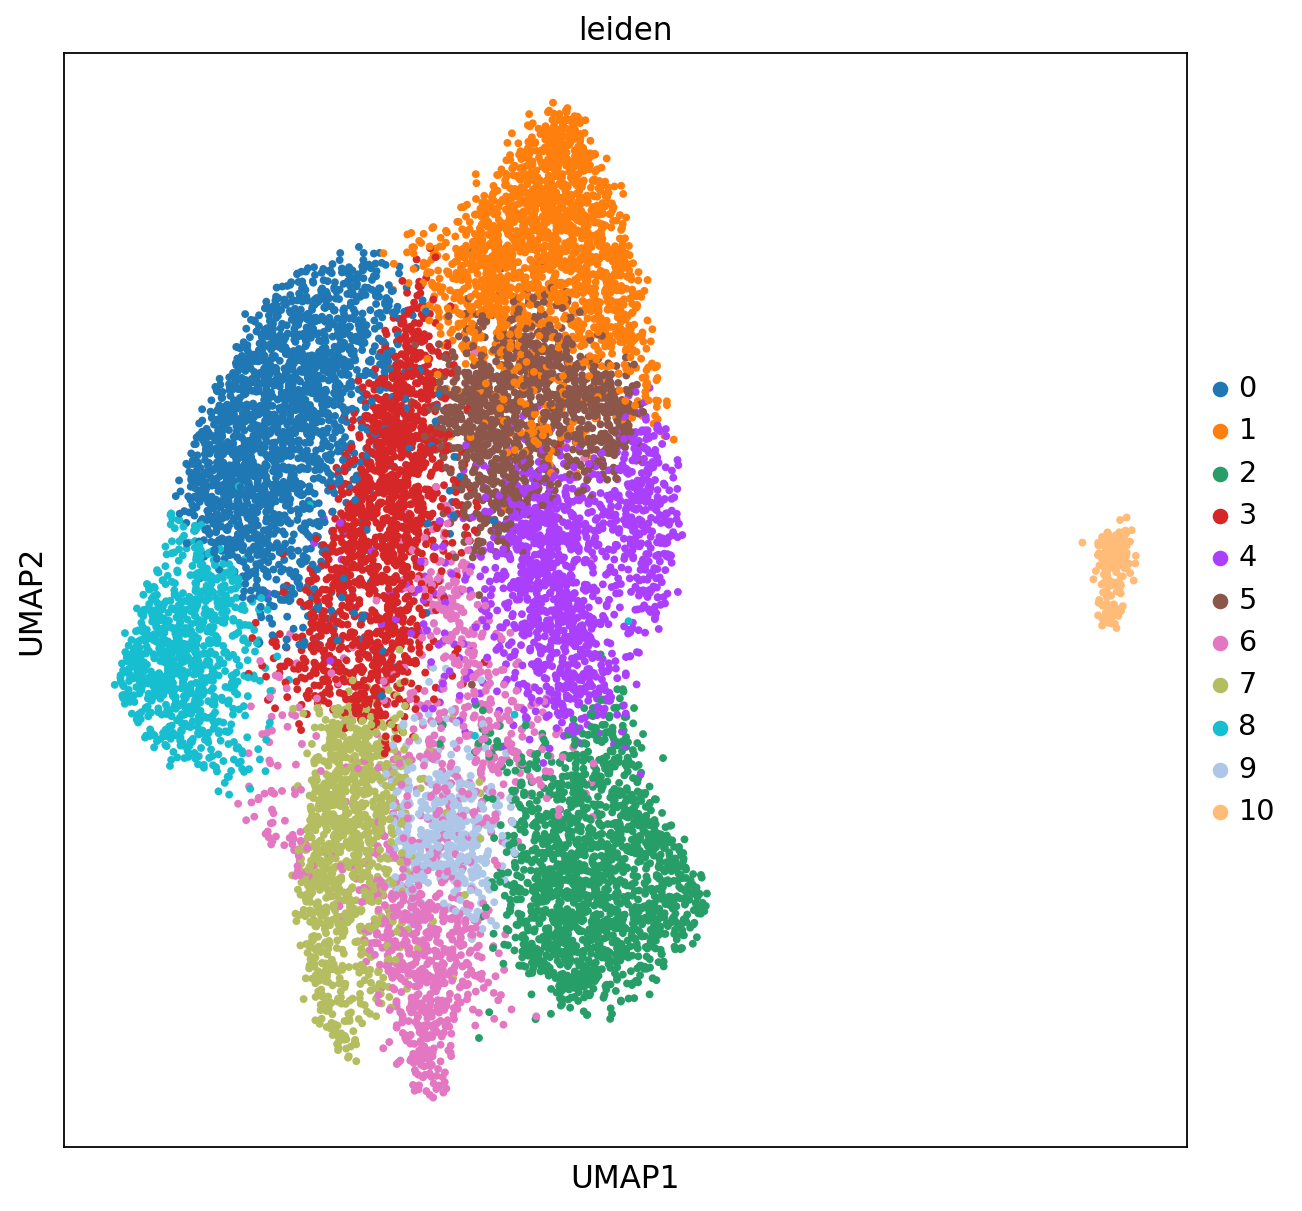

In [73]:
sc.pl.umap(rice_single_cell_slimmed_to_orthologs, color = 'leiden', s=50,)
rice_single_cell_slimmed_to_orthologs.obs['Cluster Before Gene Trimming'] =rice_single_cell_slimmed_to_orthologs.obs['leiden']

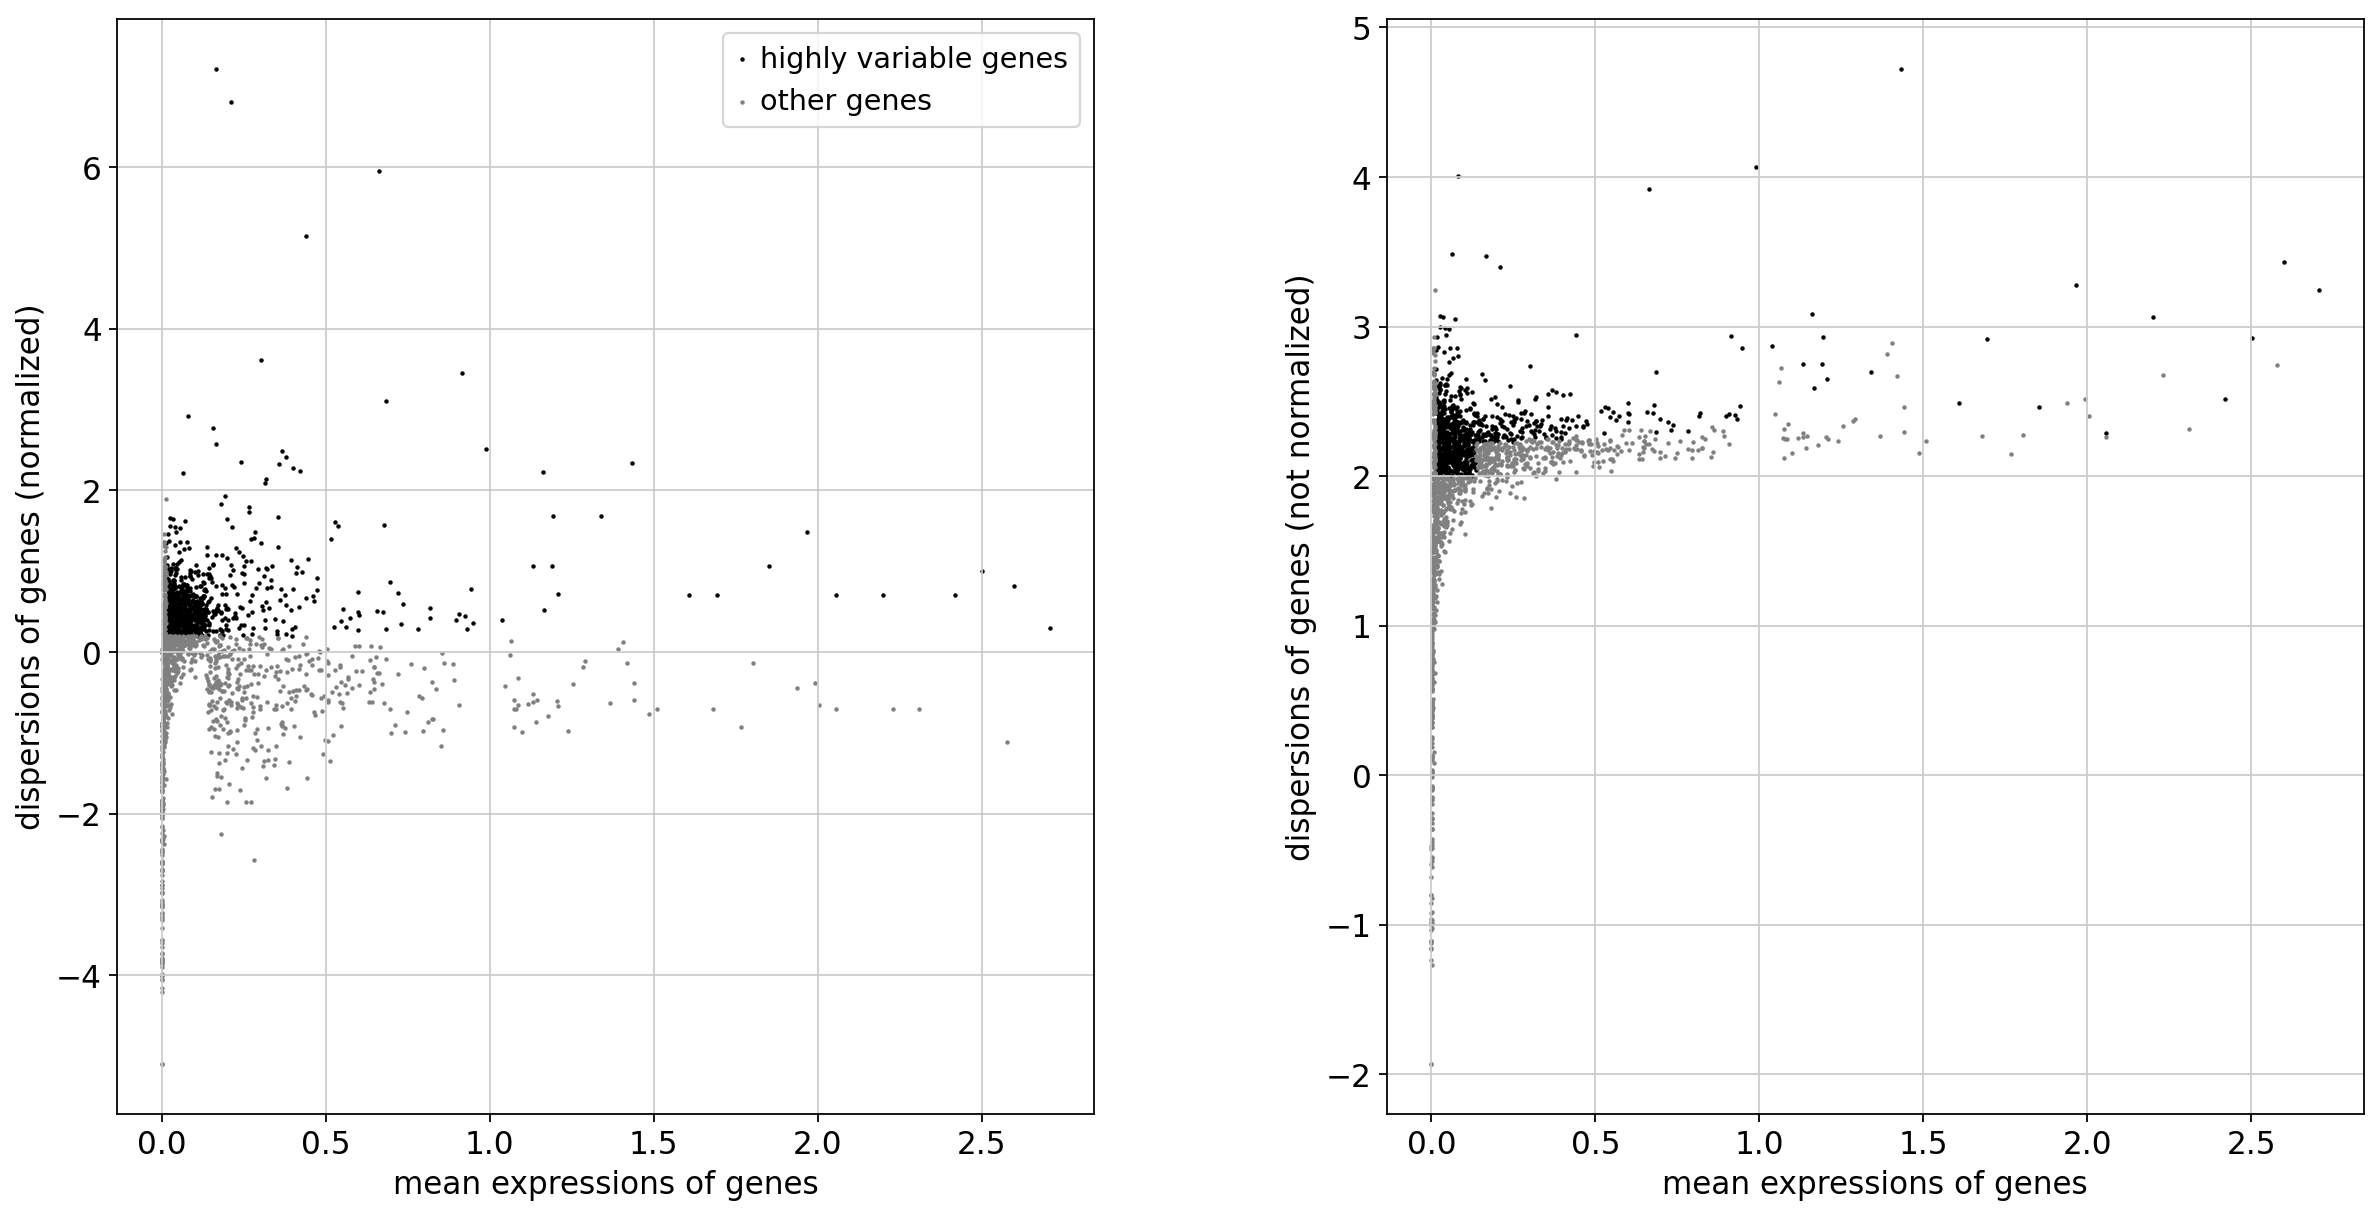

In [74]:
sc.pp.highly_variable_genes(maize_single_cell_trimmed_to_orthologs, min_mean=0.0125, max_mean=3, min_disp=.2)
sc.pl.highly_variable_genes(maize_single_cell_trimmed_to_orthologs)

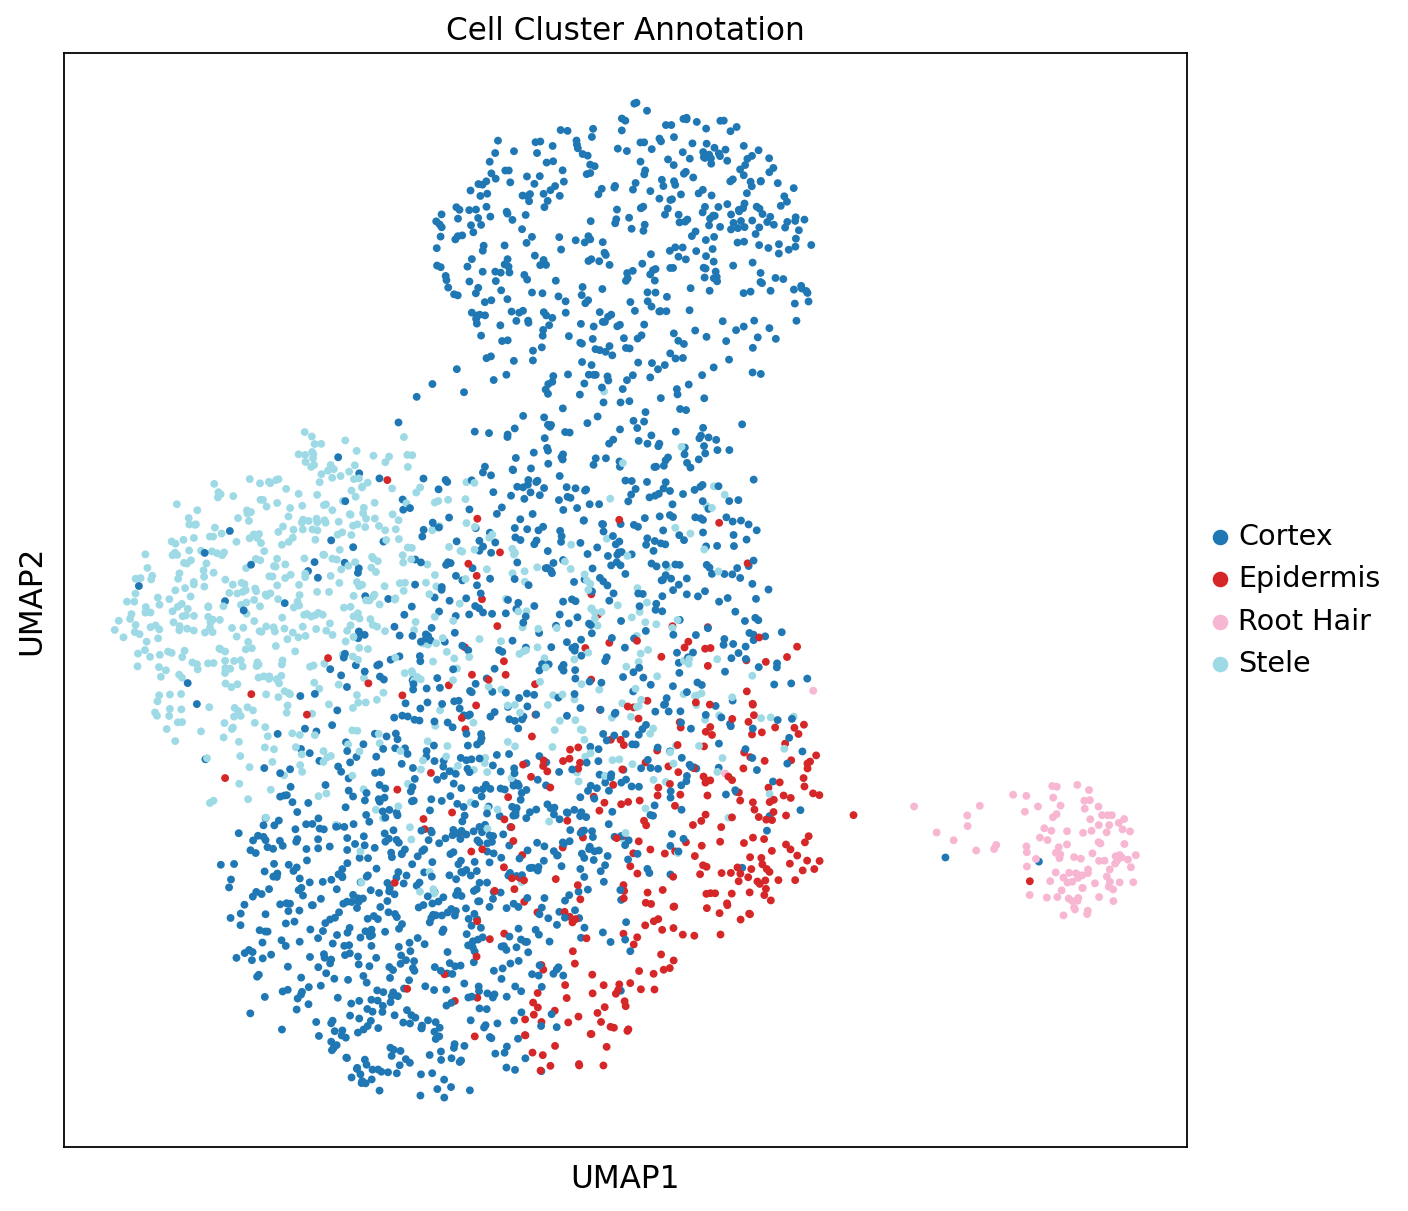

In [75]:
sc.tl.pca(maize_single_cell_trimmed_to_orthologs, svd_solver='arpack', random_state= 2435)
sc.pp.neighbors(maize_single_cell_trimmed_to_orthologs, n_neighbors=30, n_pcs=50, random_state= 68) ##30,50 # 25,45
sc.tl.umap(maize_single_cell_trimmed_to_orthologs, random_state= 253)
sc.tl.leiden(maize_single_cell_trimmed_to_orthologs, random_state= 456,)

sc.pl.umap(maize_single_cell_trimmed_to_orthologs, color = 'Cell Cluster Annotation', s=50,)

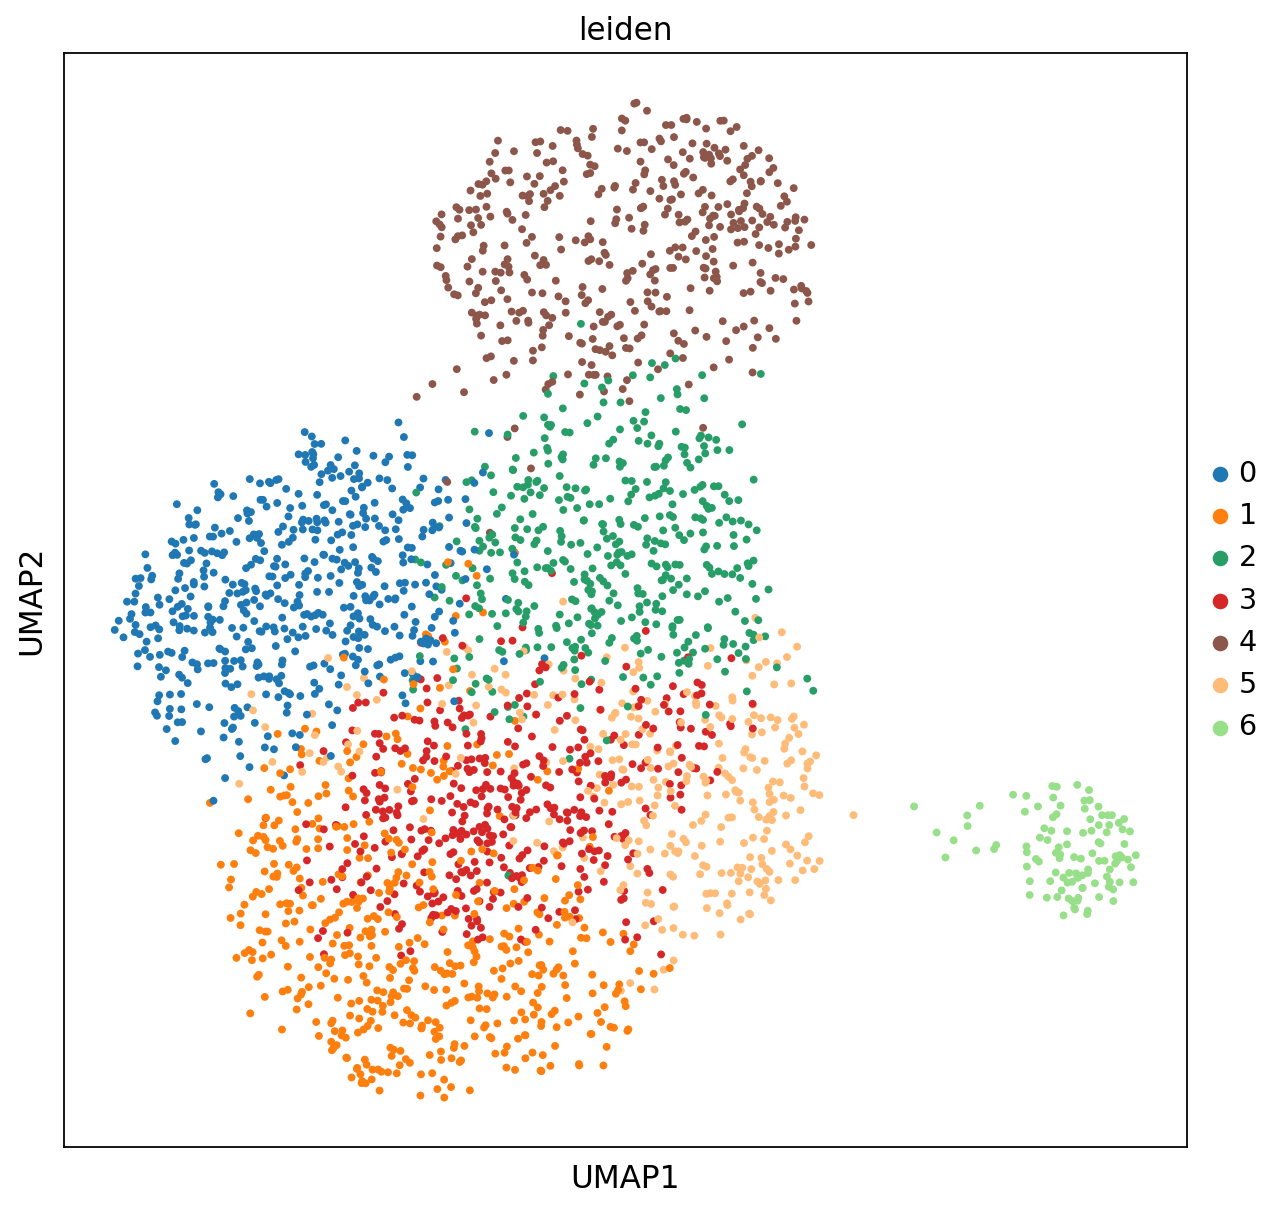

In [76]:
sc.pl.umap(maize_single_cell_trimmed_to_orthologs, color = 'leiden', s=50,)
maize_single_cell_trimmed_to_orthologs.obs['Cluster Before Gene Trimming'] =maize_single_cell_trimmed_to_orthologs.obs['leiden']

In [77]:
maize_single_cell_trimmed_to_orthologs

AnnData object with n_obs × n_vars = 2832 × 1909
    obs: 'n_genes', 'leiden', 'Cell Cluster Annotation', 'Cluster Before Gene Trimming'
    var: 'feature_types', 'In CoCoCoNet', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'Maize Gene', 'Rice Gene'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors', 'Cell Cluster Annotation_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [78]:
ultra_trimmed_rice = sc.pp.subsample(rice_single_cell_slimmed_to_orthologs, n_obs = 3500, random_state = 221, copy = True)
ultra_trimmed_rice

AnnData object with n_obs × n_vars = 3500 × 1909
    obs: 'leiden', 'Cell Cluster Annotation', 'Cluster Before Gene Trimming'
    var: 'gene_ids', 'feature_types', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'Maize Gene', 'Rice Gene'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors', 'Cell Cluster Annotation_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [79]:
concatendated_rice_maize_dataset = maize_single_cell_trimmed_to_orthologs.concatenate(ultra_trimmed_rice, batch_key = 'Species', batch_categories = ['Maize','Rice'])
concatendated_rice_maize_dataset.var.index.rename('Gene', inplace = True)
concatendated_rice_maize_dataset.obs.index.rename('CellID', inplace = True)

/home/passala/miniconda3/envs/Single_cell_data_fix/lib/python3.9/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


In [80]:
#concatendated_rice_maize_dataset.write_loom('/data/passala/Generated_Tables/Temp_junk/slimmed_concatenated_rice_maize_genes_aligned_by_only_one_to_ones.loom')

In [81]:

# concatendated_rice_maize_dataset = maize_single_cell_trimmed_to_orthologs.concatenate(rice_single_cell_slimmed_to_orthologs, batch_key = 'Species', batch_categories = ['Maize','Rice'])
# #sc.tl.pca(concatendated_rice_maize_dataset, svd_solver='arpack', )

# sc.external.pp.harmony_integrate(concatendated_rice_maize_dataset,'Species')
# sc.pp.neighbors(concatendated_rice_maize_dataset, n_neighbors = 10, n_pcs = 40, use_rep= 'X_pca_harmony', random_state = 2204)
# sc.tl.umap(concatendated_rice_maize_dataset, random_state= 243)
# sc.pl.umap(concatendated_rice_maize_dataset, color= ['Species', 'Cell Cluster Annotation'], s = 40,)

In [82]:
# import scanorama
# concatendated_rice_maize_dataset = maize_single_cell_trimmed_to_orthologs.concatenate(rice_single_cell_slimmed_to_orthologs, batch_key = 'Species', batch_categories = ['Maize','Rice'])
# #sc.tl.pca(concatendated_rice_maize_dataset, svd_solver='arpack', )

# sc.external.pp.scanorama_integrate(concatendated_rice_maize_dataset,'Species')
# sc.pp.neighbors(concatendated_rice_maize_dataset, n_neighbors = 10, n_pcs = 40, use_rep= 'X_scanorama', random_state = 2204)
# sc.tl.umap(concatendated_rice_maize_dataset, random_state= 243)
# sc.pl.umap(concatendated_rice_maize_dataset, color= ['Species', 'Cell Cluster Annotation'], s = 40,)

In [83]:
# maize_cells = concatendated_rice_maize_dataset.obs.loc[concatendated_rice_maize_dataset.obs['Species'] == 'Maize'].index
# rice_cells = concatendated_rice_maize_dataset.obs.loc[concatendated_rice_maize_dataset.obs['Species'] == 'Rice'].index


In [84]:
# sc.pl.umap(concatendated_rice_maize_dataset[maize_cells,:], color= ['Species', 'Cell Cluster Annotation'], s = 40,)
# sc.pl.umap(concatendated_rice_maize_dataset[rice_cells,:], color= ['Species', 'Cell Cluster Annotation'], s = 40)


In [85]:
# concatendated_rice_maize_dataset[maize_cells,:].obs

In [86]:
# sc.pl.umap(concatendated_rice_maize_dataset, color= ['Species', 'Cell Cluster Annotation'],palette = 'Set1', s = 60,)

In [87]:
# sc.pl.umap(concatendated_rice_maize_dataset, color= ['Species', 'leiden'], s = 40,)

In [88]:
# concatendated_rice_maize_dataset = maize_single_cell_trimmed_to_orthologs.concatenate(rice_single_cell_slimmed_to_orthologs, batch_key = 'Species', batch_categories = ['Maize','Rice'])


In [89]:
import pymn


In [90]:
# pymn.variableGenes(concatendated_rice_maize_dataset,study_col = 'Species')
# pymn.MetaNeighborUS(concatendated_rice_maize_dataset,study_col = 'Species',ct_col = 'Cell Cluster Annotation')
# g = pymn.plotMetaNeighborUS(concatendated_rice_maize_dataset,figsize = (20,20),cmap = 'coolwarm',fontsize = 15,show = False,)
# #g.savefig('/home/passala/Gene_duplication_project/Code/Bruno_maize_sorghum_proj')

In [91]:
# pymn.variableGenes(concatendated_rice_maize_dataset,study_col = 'Species')
# pymn.MetaNeighborUS(concatendated_rice_maize_dataset,study_col = 'Species',ct_col = 'Cluster Before Gene Trimming')
# g = pymn.plotMetaNeighborUS(concatendated_rice_maize_dataset,figsize = (20,20),cmap = 'coolwarm',fontsize = 15,show = False,)
# #g.savefig('/home/passala/Gene_duplication_project/Code/Bruno_maize_sorghum_proj')

In [92]:
# concatendated_rice_maize_dataset.obs['Combined_Pre_trimming_clusters'] = concatendated_rice_maize_dataset.obs['Cluster Before Gene Trimming']

# concatendated_rice_maize_dataset.obs['Combined_Pre_trimming_clusters'].loc[(concatendated_rice_maize_dataset.obs['Cluster Before Gene Trimming'].isin(['1','14',]))&(concatendated_rice_maize_dataset.obs['Species'] == 'Rice')] = '1+14'
# concatendated_rice_maize_dataset.obs['Combined_Pre_trimming_clusters'].loc[(concatendated_rice_maize_dataset.obs['Cluster Before Gene Trimming'].isin(['6','9','8']))&(concatendated_rice_maize_dataset.obs['Species'] == 'Rice')] = '6+9+8'
# concatendated_rice_maize_dataset.obs['Combined_Pre_trimming_clusters'].loc[(concatendated_rice_maize_dataset.obs['Cluster Before Gene Trimming'].isin(['2','12',]))&(concatendated_rice_maize_dataset.obs['Species'] == 'Rice')] = '2+12'
# concatendated_rice_maize_dataset.obs['Combined_Pre_trimming_clusters'].loc[(concatendated_rice_maize_dataset.obs['Cluster Before Gene Trimming'].isin(['4','7',]))&(concatendated_rice_maize_dataset.obs['Species'] == 'Rice')] = '4+7'
# concatendated_rice_maize_dataset.obs['Combined_Pre_trimming_clusters'].loc[(concatendated_rice_maize_dataset.obs['Cluster Before Gene Trimming'].isin(['10','5',]))&(concatendated_rice_maize_dataset.obs['Species'] == 'Rice')] = '10+5'


# concatendated_rice_maize_dataset.obs['Combined_Pre_trimming_clusters'].loc[(concatendated_rice_maize_dataset.obs['Cluster Before Gene Trimming'].isin(['5','6',]))&(concatendated_rice_maize_dataset.obs['Species'] == 'Maize')] = '6+5'
# concatendated_rice_maize_dataset.obs['Combined_Pre_trimming_clusters'].loc[(concatendated_rice_maize_dataset.obs['Cluster Before Gene Trimming'].isin(['3','8',]))&(concatendated_rice_maize_dataset.obs['Species'] == 'Maize')] = '3+8'


In [93]:
# pymn.variableGenes(concatendated_rice_maize_dataset,study_col = 'Species')
# pymn.MetaNeighborUS(concatendated_rice_maize_dataset,study_col = 'Species',ct_col = 'Combined_Pre_trimming_clusters')
# g = pymn.plotMetaNeighborUS(concatendated_rice_maize_dataset,figsize = (20,20),cmap = 'coolwarm',fontsize = 15,show = False,)
# #g.savefig('/home/passala/Gene_duplication_project/Code/Bruno_maize_sorghum_proj')

In [94]:
# concatendated_rice_maize_dataset = maize_single_cell_trimmed_to_orthologs.concatenate(rice_single_cell_slimmed_to_orthologs, batch_key = 'Species', batch_categories = ['Maize','Rice'])


In [95]:
# sc.pp.highly_variable_genes(concatendated_rice_maize_dataset, min_mean=0.0125, max_mean=3, min_disp=0.3, batch_key = 'Species')


In [96]:
# var_select = concatendated_rice_maize_dataset.var.highly_variable_nbatches > 1
# var_genes = var_select.index[var_select]

In [97]:
# batches = concatendated_rice_maize_dataset.obs['Species'].cat.categories.tolist()
# alldata = {}
# for batch in batches:
#     alldata[batch] = concatendated_rice_maize_dataset[concatendated_rice_maize_dataset.obs['Species'] == batch,]

# alldata 

In [98]:
# concatendated_rice_maize_dataset = maize_single_cell_trimmed_to_orthologs.concatenate(rice_single_cell_slimmed_to_orthologs, batch_key = 'Species', batch_categories = ['Maize','Rice'])


In [99]:
# concatendated_rice_maize_dataset.obs

In [100]:
import scgen

Global seed set to 0


/home/passala/miniconda3/envs/Single_cell_data_fix/lib/python3.9/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/home/passala/miniconda3/envs/Single_cell_data_fix/lib/python3.9/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)


In [101]:
concatendated_rice_maize_dataset = maize_single_cell_trimmed_to_orthologs.concatenate(ultra_trimmed_rice, batch_key = 'Species', batch_categories = ['Maize','Rice'])
concatendated_rice_maize_dataset.var.index.rename('Gene', inplace = True)
concatendated_rice_maize_dataset.obs.index.rename('CellID', inplace = True)

/home/passala/miniconda3/envs/Single_cell_data_fix/lib/python3.9/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


In [ ]:
scgen.SCGEN.setup_anndata(concatendated_rice_maize_dataset, batch_key="Species", labels_key="Cell Cluster Annotation")


In [144]:
model = scgen.SCGEN(concatendated_rice_maize_dataset)

In [145]:
model.train(
    max_epochs=100,
    batch_size=32,
    early_stopping=True,
    early_stopping_patience=10,
)

/home/passala/miniconda3/envs/Single_cell_data_fix/lib/python3.9/site-packages/scvi/model/base/_training_mixin.py:67: UserWarning: max_epochs=100 is less than n_epochs_kl_warmup=400. The max_kl_weight will not be reached during training.
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 11/100:  11%|█         | 11/100 [00:37<05:00,  3.38s/it, loss=83.1, v_num=1]
Monitored metric elbo_validation did not improve in the last 10 records. Best score: 524.347. Signaling Trainer to stop.


In [158]:
# model.save('/data/passala/Coexpressolog_paper_data/Models/post_revision_11_only_current_model')

In [103]:
import scgen
model = scgen.SCGEN.load('/data/passala/Coexpressolog_paper_data/Models/post_revision_11_only_current_model', adata =concatendated_rice_maize_dataset)

INFO     File /data/passala/Coexpressolog_paper_data/Models/post_revision_11_only_current_model/model.pt already   
         downloaded                                                                                                


In [104]:
corrected_adata = model.batch_removal()
corrected_adata

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/passala/miniconda3/envs/Single_cell_data_fix/lib/python3.9/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


AnnData object with n_obs × n_vars = 6332 × 1909
    obs: 'n_genes', 'leiden', 'Cell Cluster Annotation', 'Cluster Before Gene Trimming', 'Species', '_scvi_batch', '_scvi_labels'
    uns: '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'latent', 'corrected_latent'

         Falling back to preprocessing with `sc.pp.pca` and default params.


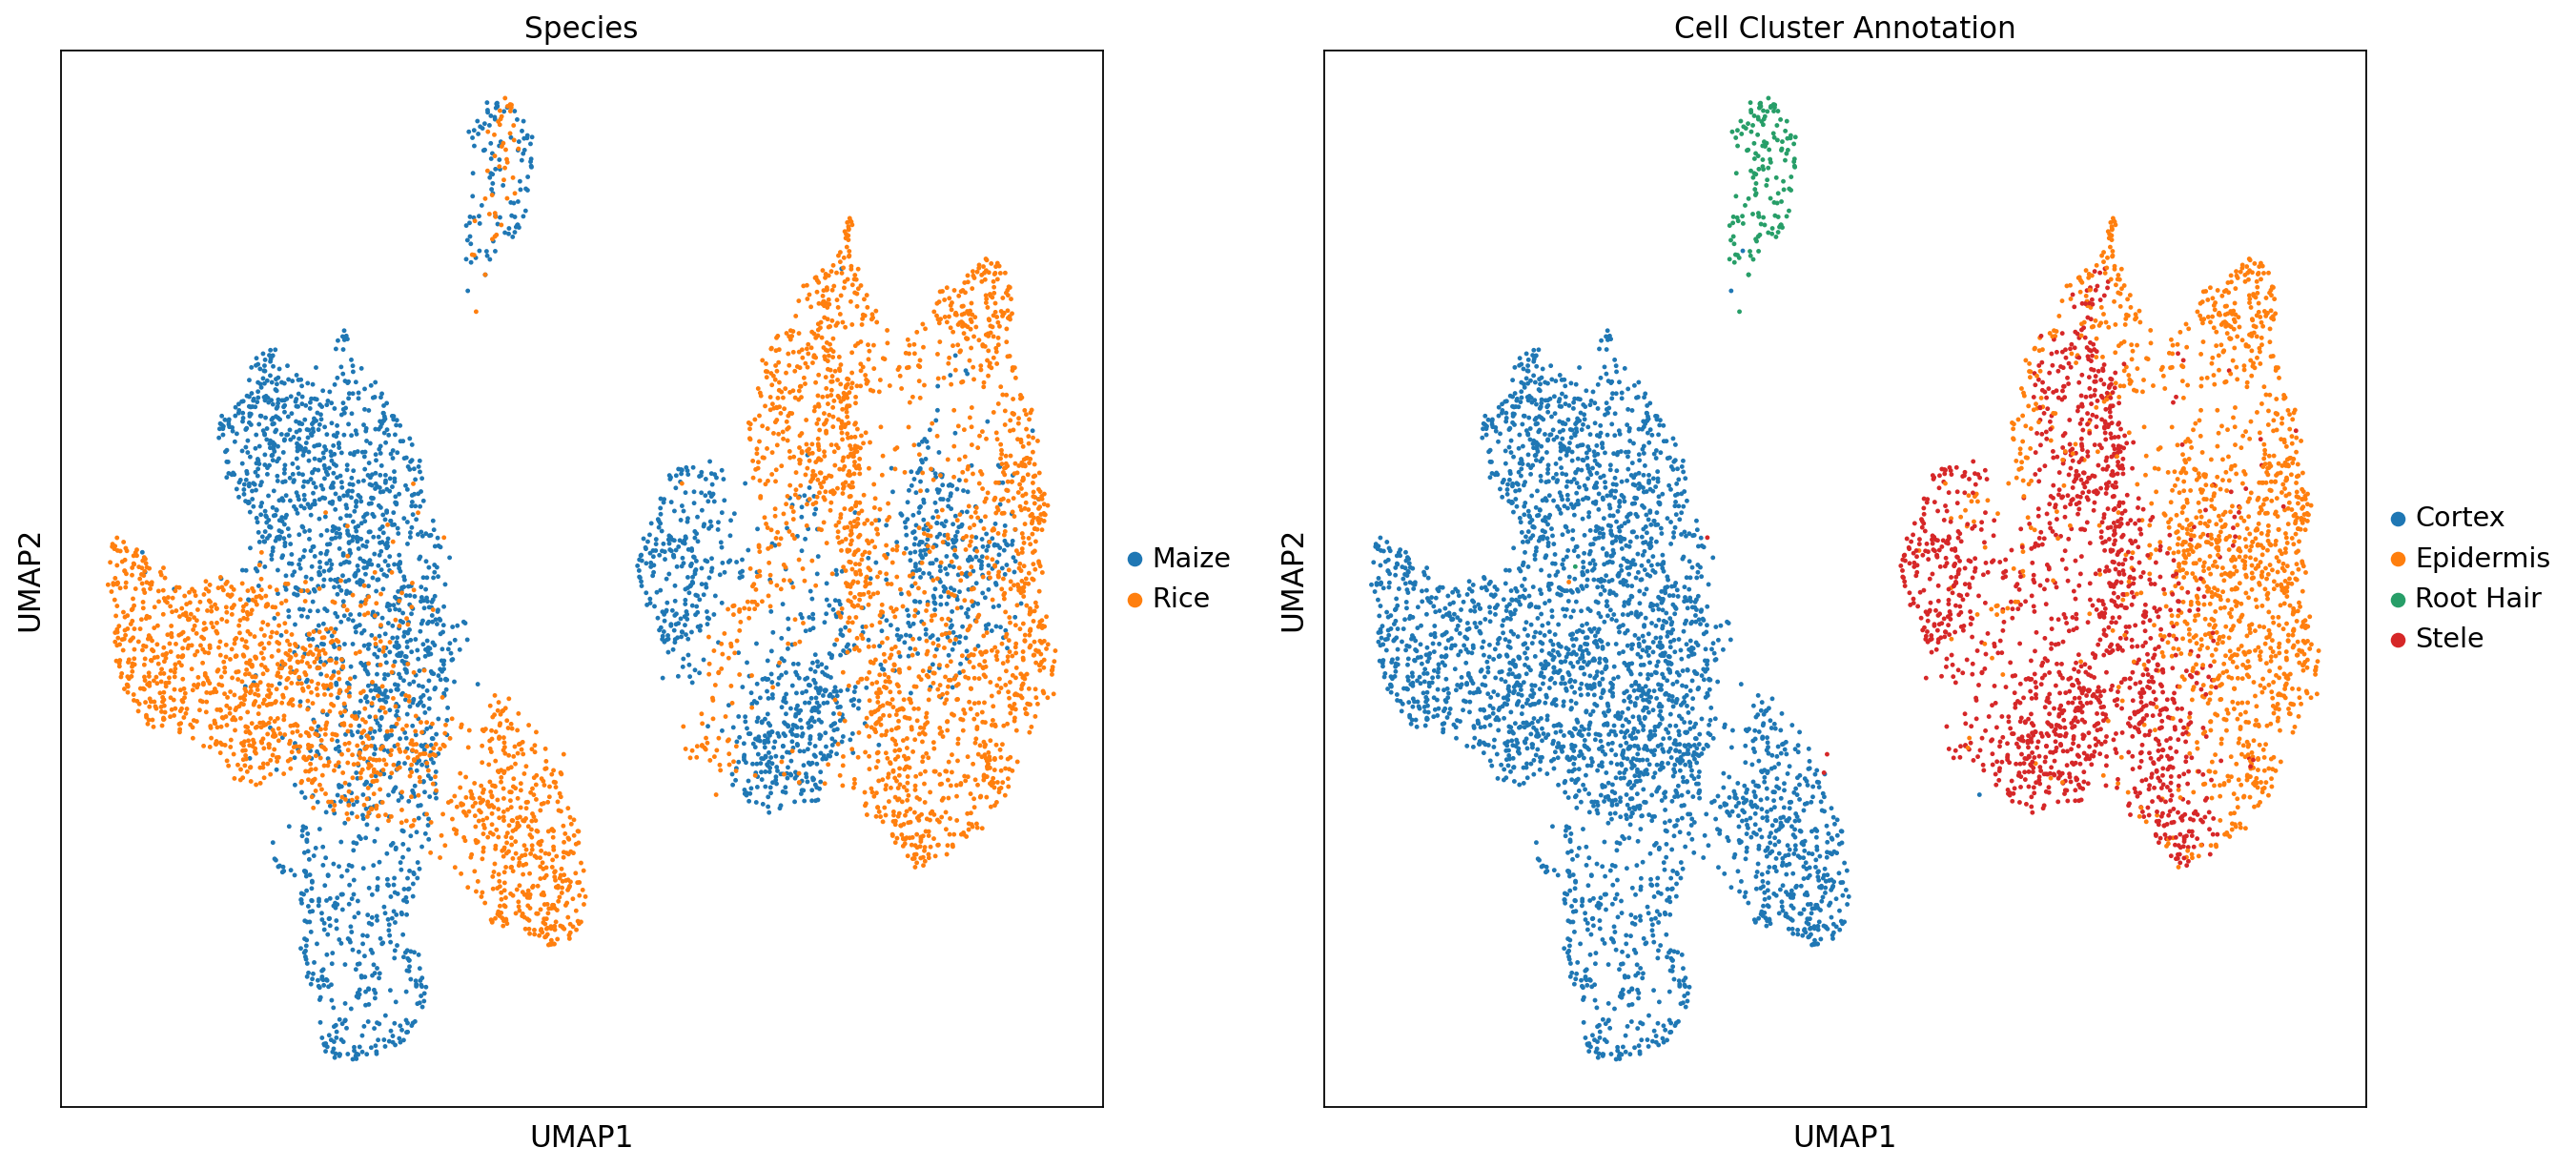

In [105]:
sc.pp.neighbors(corrected_adata)
sc.tl.umap(corrected_adata)
sc.pl.umap(corrected_adata, color=['Species', 'Cell Cluster Annotation'])

In [106]:
sc.settings.figdir = '/data/passala/Plots_for_projects/Coexpressolog_paper_plots/updated_for_v11'

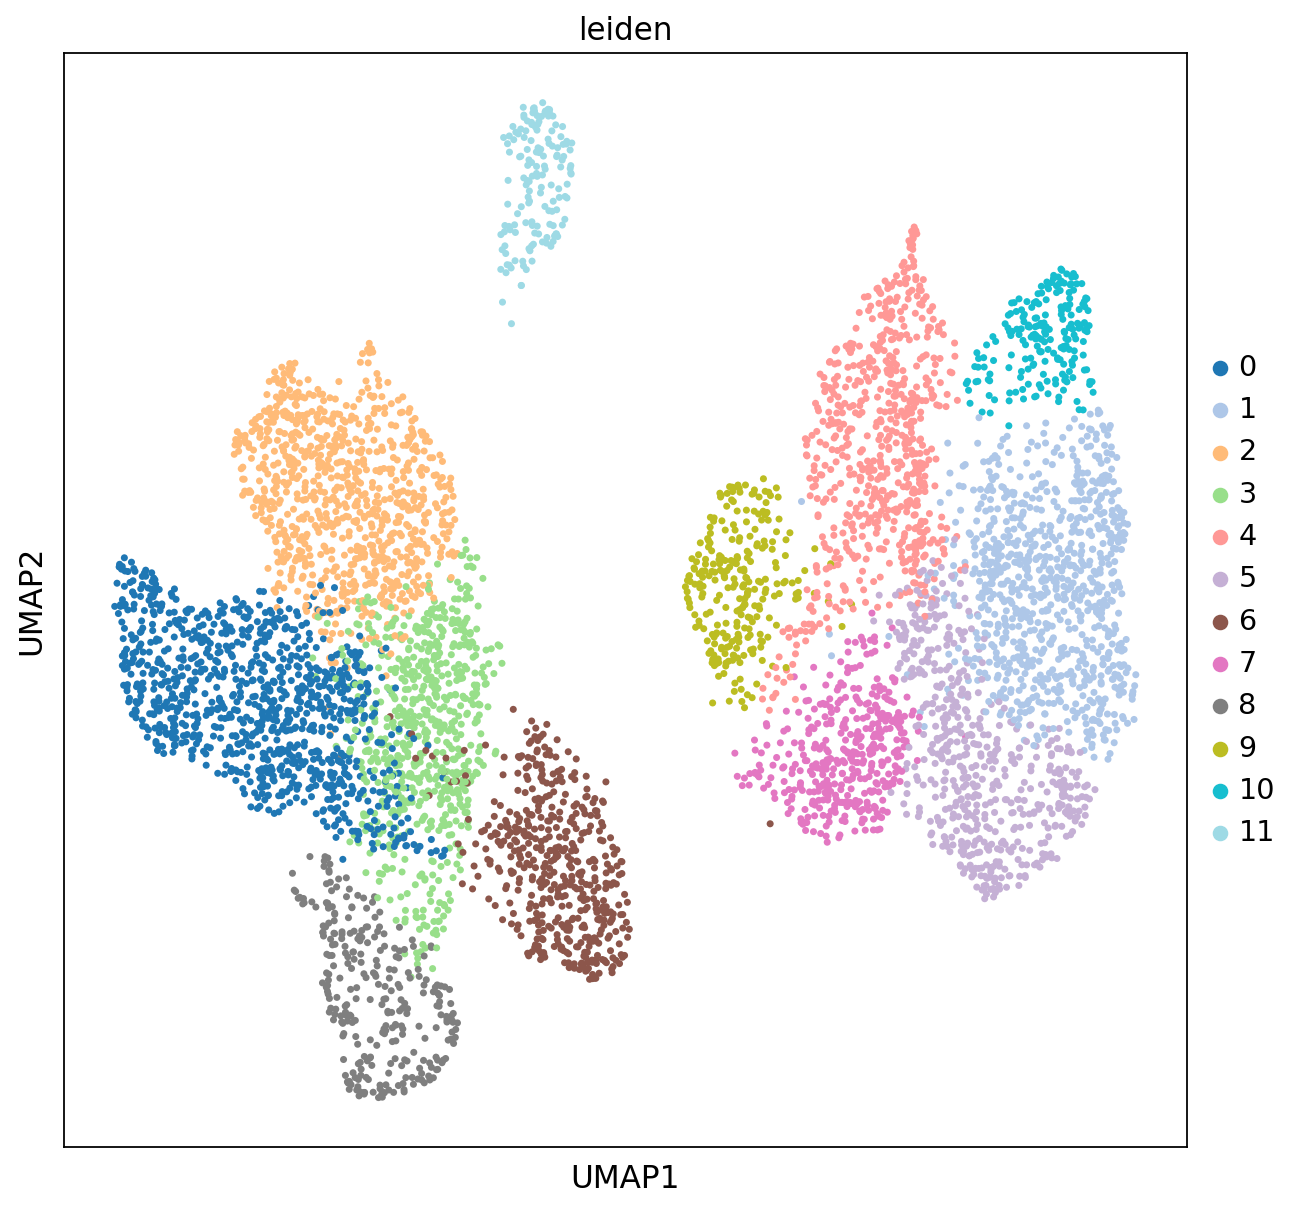

In [107]:
sc.tl.leiden(corrected_adata, random_state= 46, resolution = .5)

sc.pl.umap(corrected_adata, color= 'leiden', s = 40, palette = 'tab20')

In [108]:
real_clusters = corrected_adata.obs['leiden'].value_counts()[corrected_adata.obs['leiden'].value_counts() > 15].index.to_list()

In [109]:
trimmed_alpha_beta = corrected_adata[corrected_adata.obs['leiden'].isin(real_clusters),:]
trimmed_alpha_beta

View of AnnData object with n_obs × n_vars = 6332 × 1909
    obs: 'n_genes', 'leiden', 'Cell Cluster Annotation', 'Cluster Before Gene Trimming', 'Species', '_scvi_batch', '_scvi_labels'
    uns: '_scvi_uuid', '_scvi_manager_uuid', 'neighbors', 'umap', 'Species_colors', 'Cell Cluster Annotation_colors', 'leiden', 'leiden_colors'
    obsm: 'latent', 'corrected_latent', 'X_pca', 'X_umap'
    obsp: 'distances', 'connectivities'

In [110]:
number_cells_in_cluster_with_majority_one_cell_type = 0
number_cells_in_cluster_with_multiple_Cell_types = 0
number_cells_in_mixed_dataset = 0
number_cells_in_single_dataset = 0
for leiden_cluster in real_clusters:
    current_cell_group = trimmed_alpha_beta.obs.loc[trimmed_alpha_beta.obs['leiden'] == leiden_cluster]
    if current_cell_group['Cell Cluster Annotation'].value_counts(normalize = True).max() > .6:
        number_cells_in_cluster_with_majority_one_cell_type+= len(current_cell_group)
    else:
        number_cells_in_cluster_with_multiple_Cell_types += len(current_cell_group)
    if current_cell_group['Species'].value_counts(normalize = True).max() < .7:
        number_cells_in_mixed_dataset += len(current_cell_group)
    else: 
        number_cells_in_single_dataset+= len(current_cell_group)

In [111]:
total_cells = len(trimmed_alpha_beta.obs)
percent_cells_in_majority_one_cell_type = number_cells_in_cluster_with_majority_one_cell_type/total_cells
print(percent_cells_in_majority_one_cell_type)

1.0


In [112]:
percent_cells_in_mixed = number_cells_in_mixed_dataset/total_cells
print(percent_cells_in_mixed)

0.13566013897662665


/home/passala/miniconda3/envs/Single_cell_data_fix/lib/python3.9/site-packages/seaborn/matrix.py:1214: UserWarning: ``square=True`` ignored in clustermap
  warnings.warn(msg)


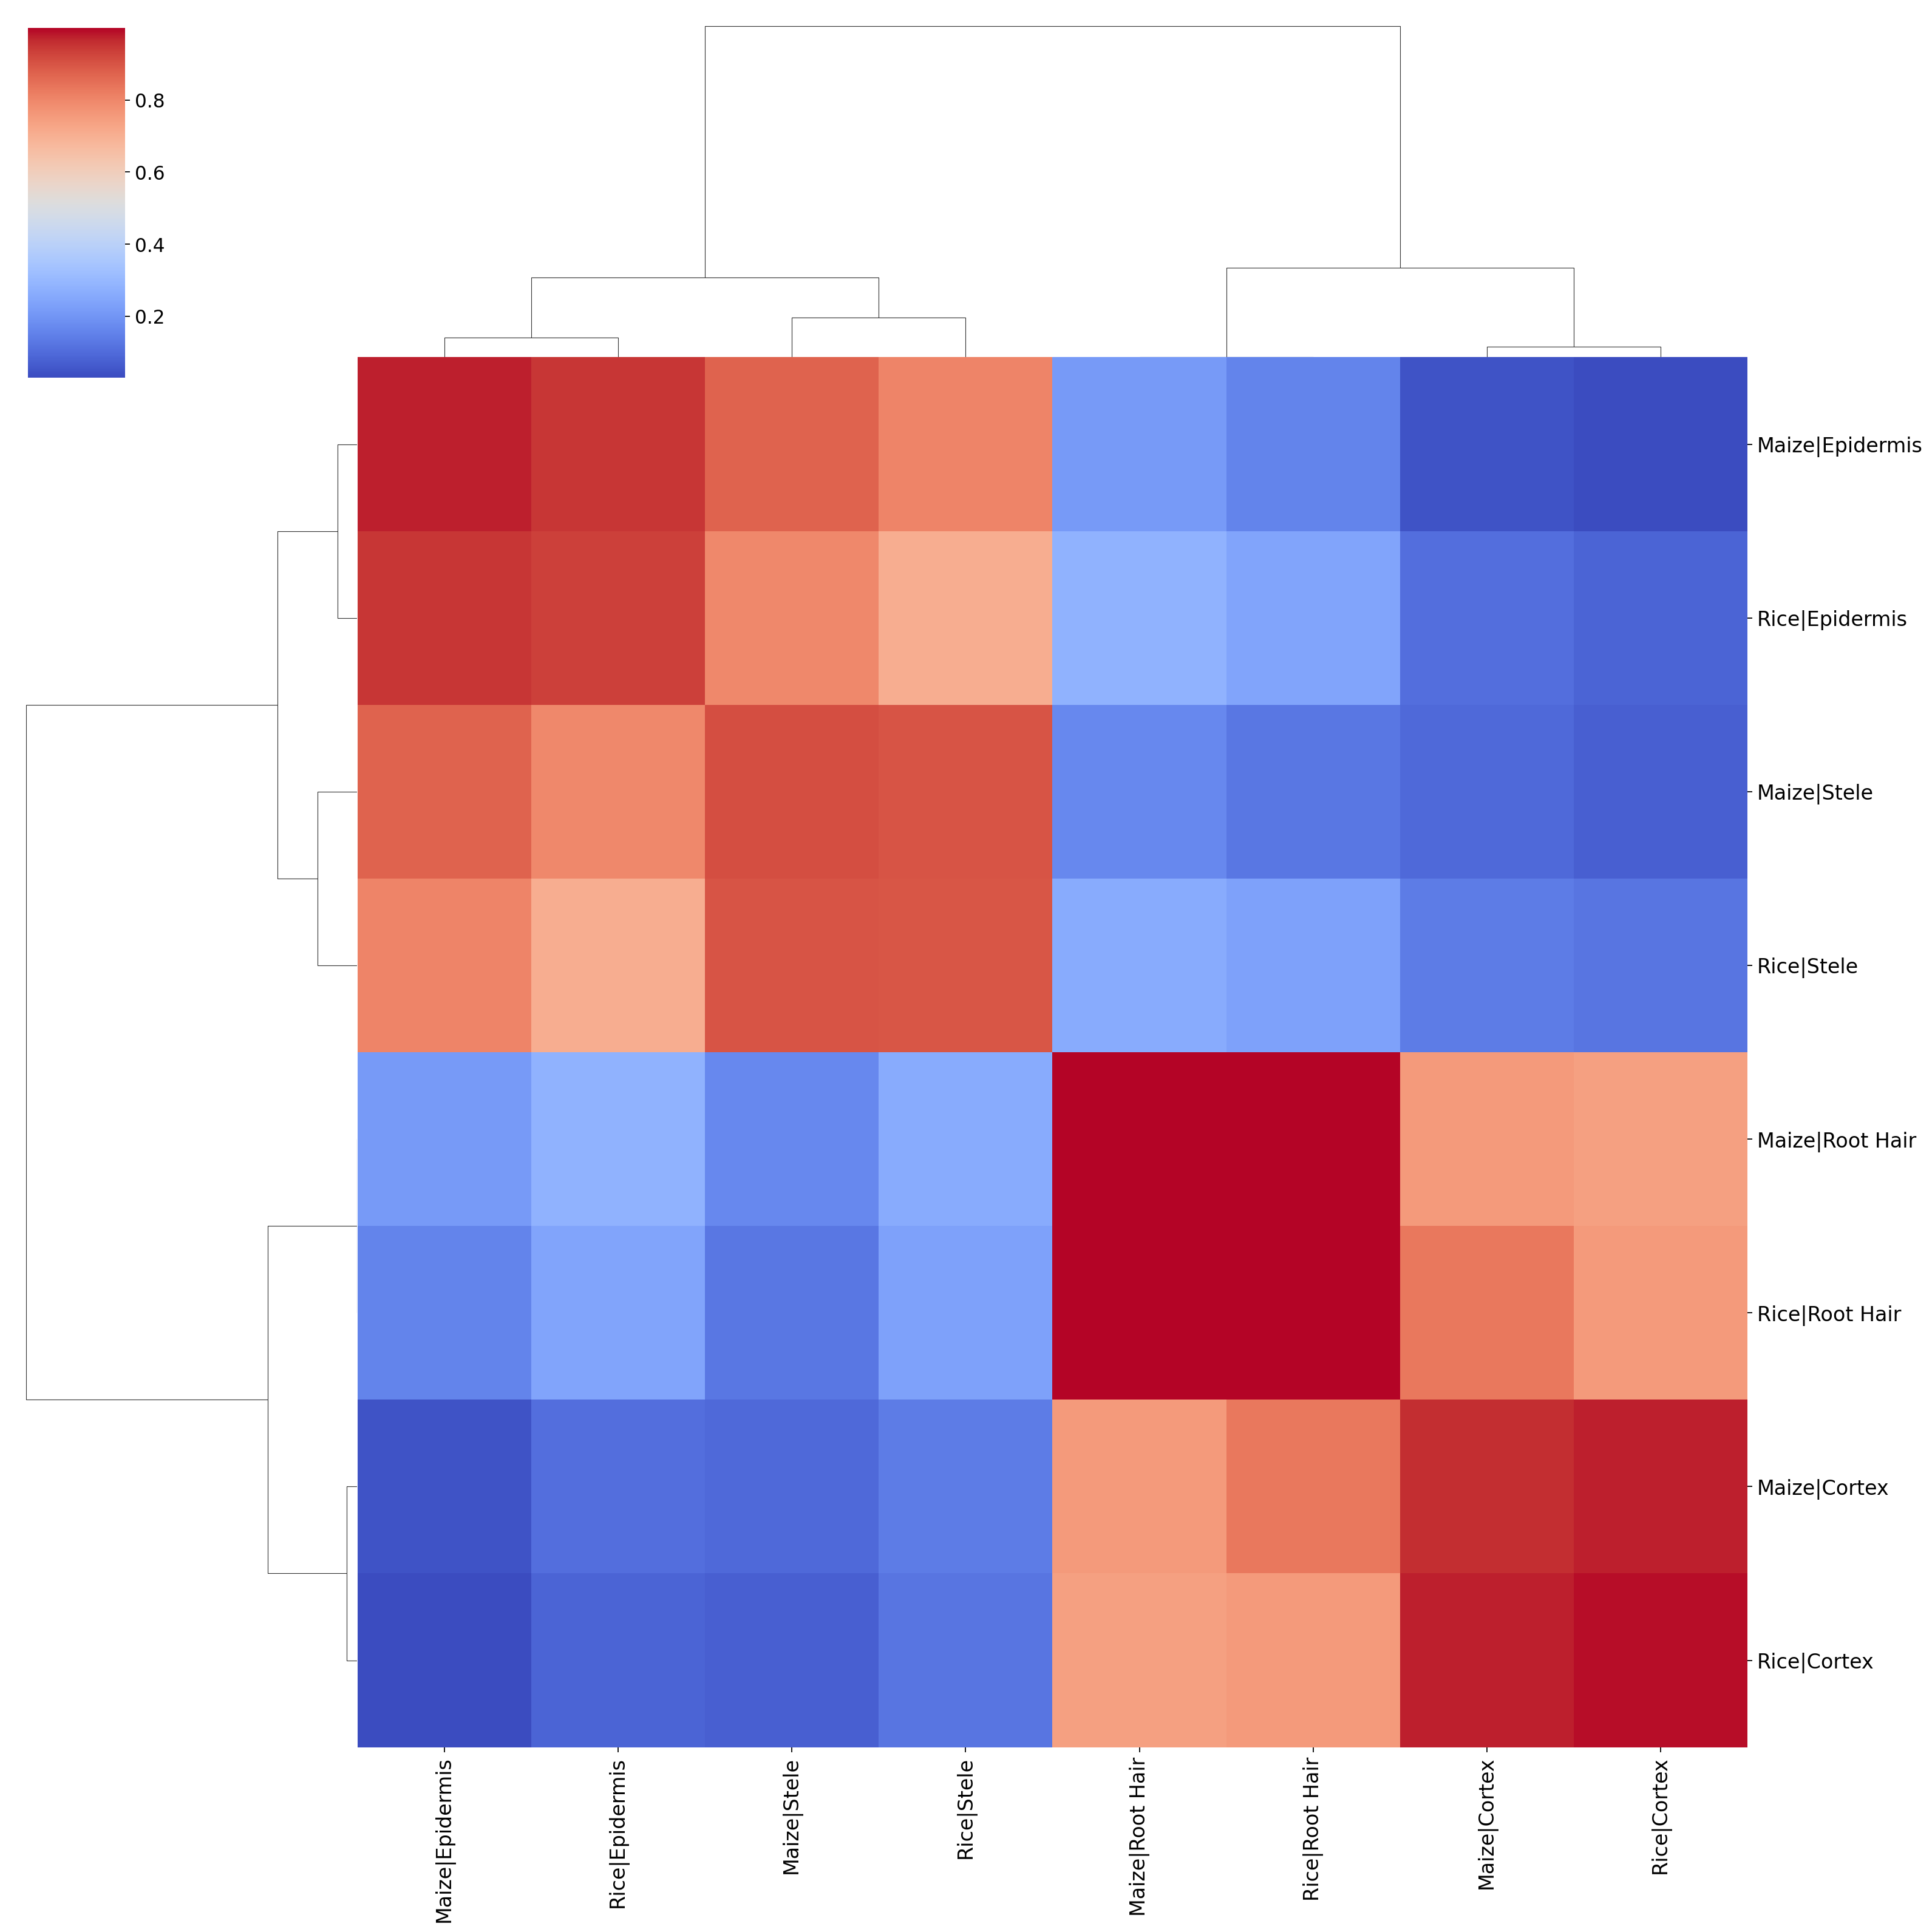

In [113]:
pymn.variableGenes(corrected_adata,study_col = 'Species')
pymn.MetaNeighborUS(corrected_adata,study_col = 'Species',ct_col = 'Cell Cluster Annotation')
g = pymn.plotMetaNeighborUS(corrected_adata,figsize = (20,20),cmap = 'coolwarm',fontsize = 15,show = False,)

In [114]:
corrected_adata.uns['MetaNeighborUS']

Maize|Cortex  Maize|Epidermis  Maize|Root Hair  Maize|Stele  \
Maize|Cortex         0.959145         0.047280         0.756052     0.095746   
Maize|Epidermis      0.047280         0.975720         0.212051     0.874796   
Maize|Root Hair      0.756052         0.212051         0.999808     0.166713   
Maize|Stele          0.095746         0.874796         0.166713     0.910208   
Rice|Cortex          0.973668         0.029645         0.739807     0.073028   
Rice|Epidermis       0.105487         0.950148         0.280189     0.796342   
Rice|Root Hair       0.829629         0.156695         0.999870     0.125667   
Rice|Stele           0.138584         0.803121         0.257887     0.898002   

                 Rice|Cortex  Rice|Epidermis  Rice|Root Hair  Rice|Stele  
Maize|Cortex        0.973668        0.105487        0.829629    0.138584  
Maize|Epidermis     0.029645        0.950148        0.156695    0.803121  
Maize|Root Hair     0.739807        0.280189        0.999870    0.257887  
Maize|Stele         0.073028        0.796342        0.125667    0.898002  
Rice|Cortex         0.989767        0.083214        0.755744    0.122276  
Rice|Epidermis      0.083214        0.934867        0.238986    0.706404  
Rice|Root Hair      0.755744        0.238986        0.999954    0.233281  
Rice|Stele          0.122276        0.706404        0.233281    0.894539

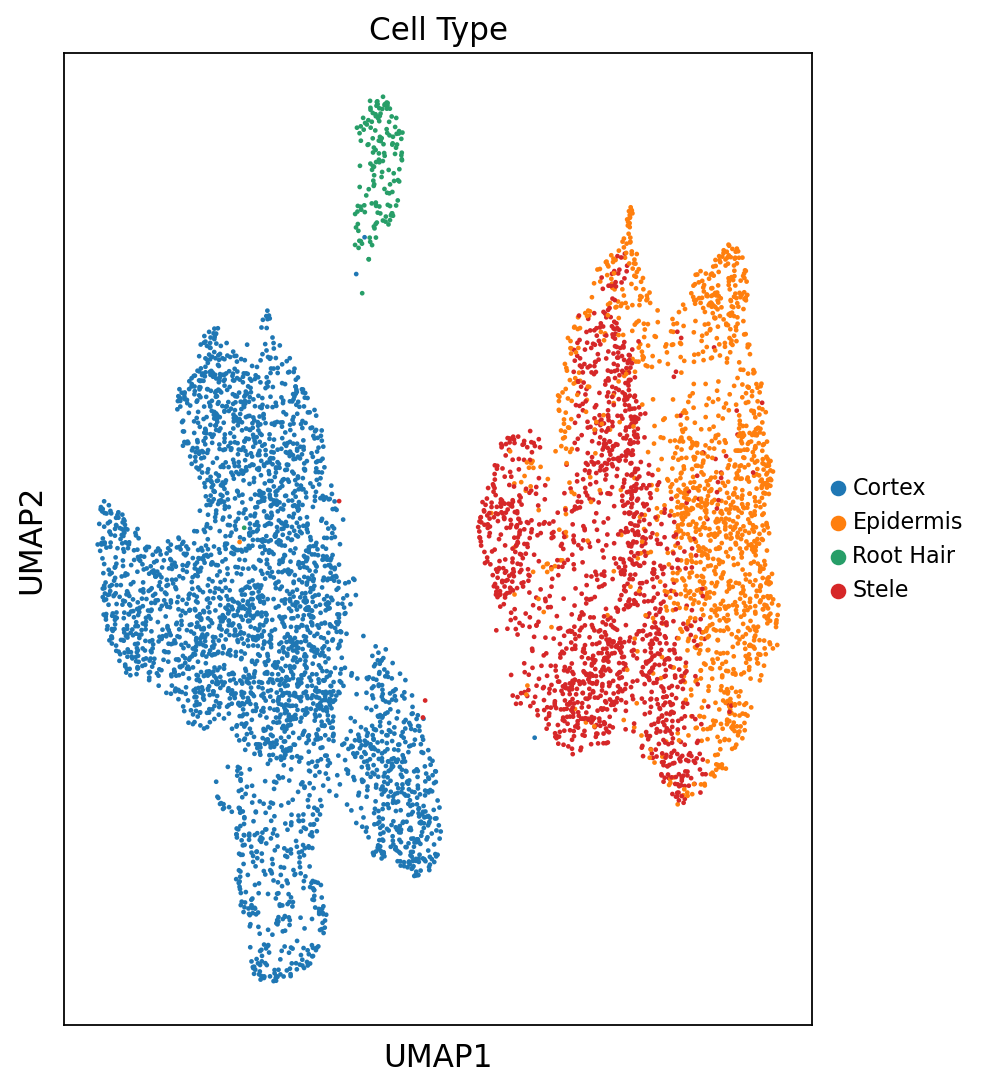

In [115]:
sc.set_figure_params(dpi_save = 500, figsize = (6,8))
#sc.pl.umap(corrected_adata, color= ['Cell Cluster Annotation'], s=18, legend_fontsize = 10, title = "Cell Type")
sc.pl.umap(corrected_adata, color= ['Cell Cluster Annotation'], s=18, legend_fontsize = 10, title = "Cell Type", save = 'one_to_one_cell_type_maize_rice_cell_type.svg')

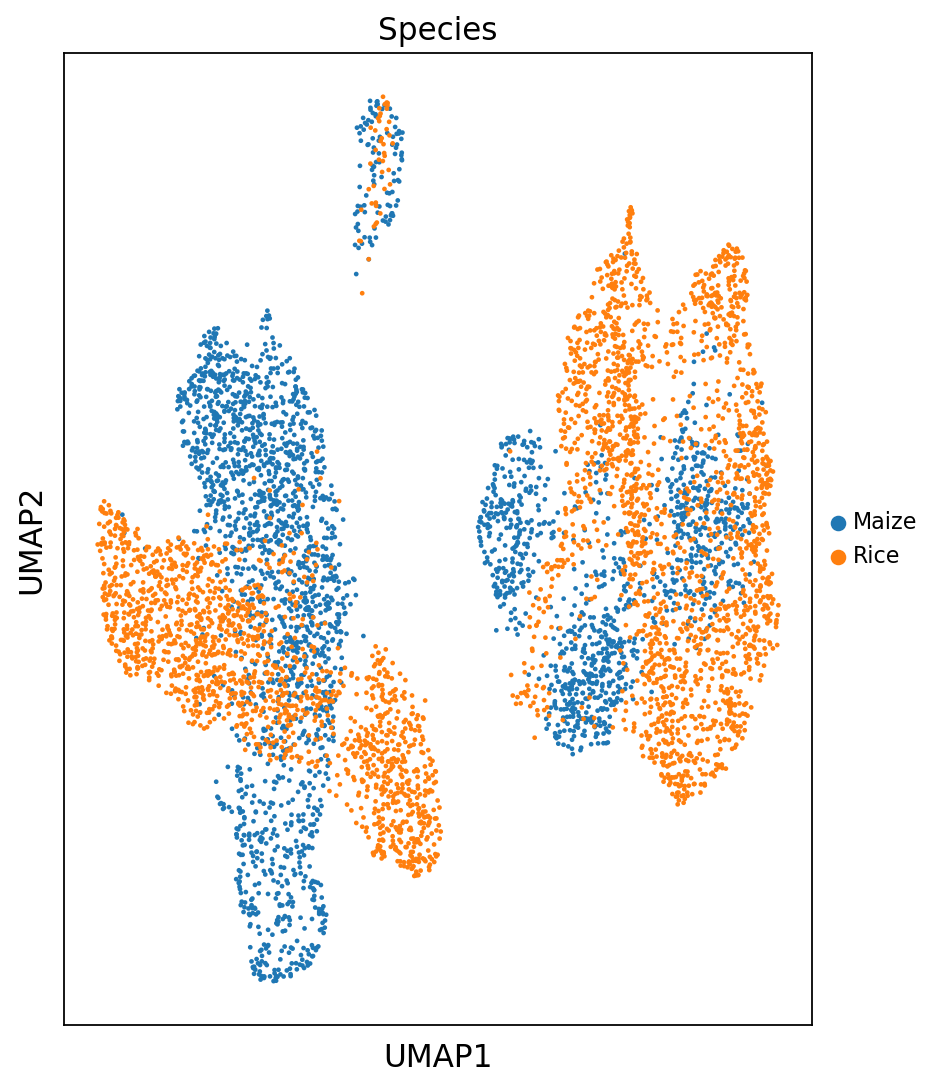

In [121]:
sc.set_figure_params(dpi_save = 500, figsize = (6,8))
#sc.pl.umap(corrected_adata, color= ['Species'], s=18, legend_fontsize = 10, title = "Species", )
sc.pl.umap(corrected_adata, color= ['Species'], s=18, legend_fontsize = 10, title = "Species", save = 'one_to_one_only_species_maize_rice_species.svg')

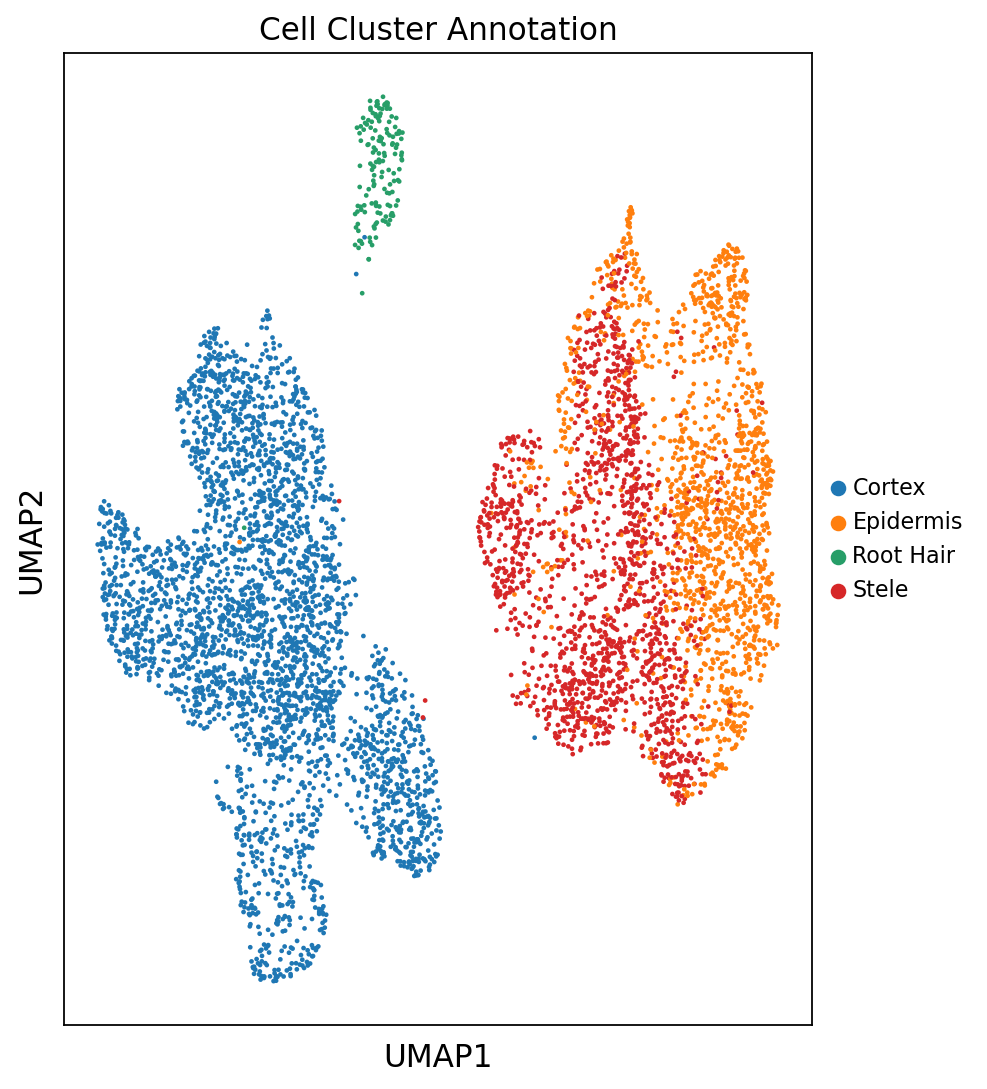

In [122]:
sc.pl.umap(corrected_adata, color= ['Cell Cluster Annotation'], s=18, legend_fontsize = 10, save = 'one_to_one_only_cell_type_maize_rice_cell_type.svg')

/home/passala/miniconda3/envs/Single_cell_data_fix/lib/python3.9/site-packages/seaborn/matrix.py:1214: UserWarning: ``square=True`` ignored in clustermap
  warnings.warn(msg)


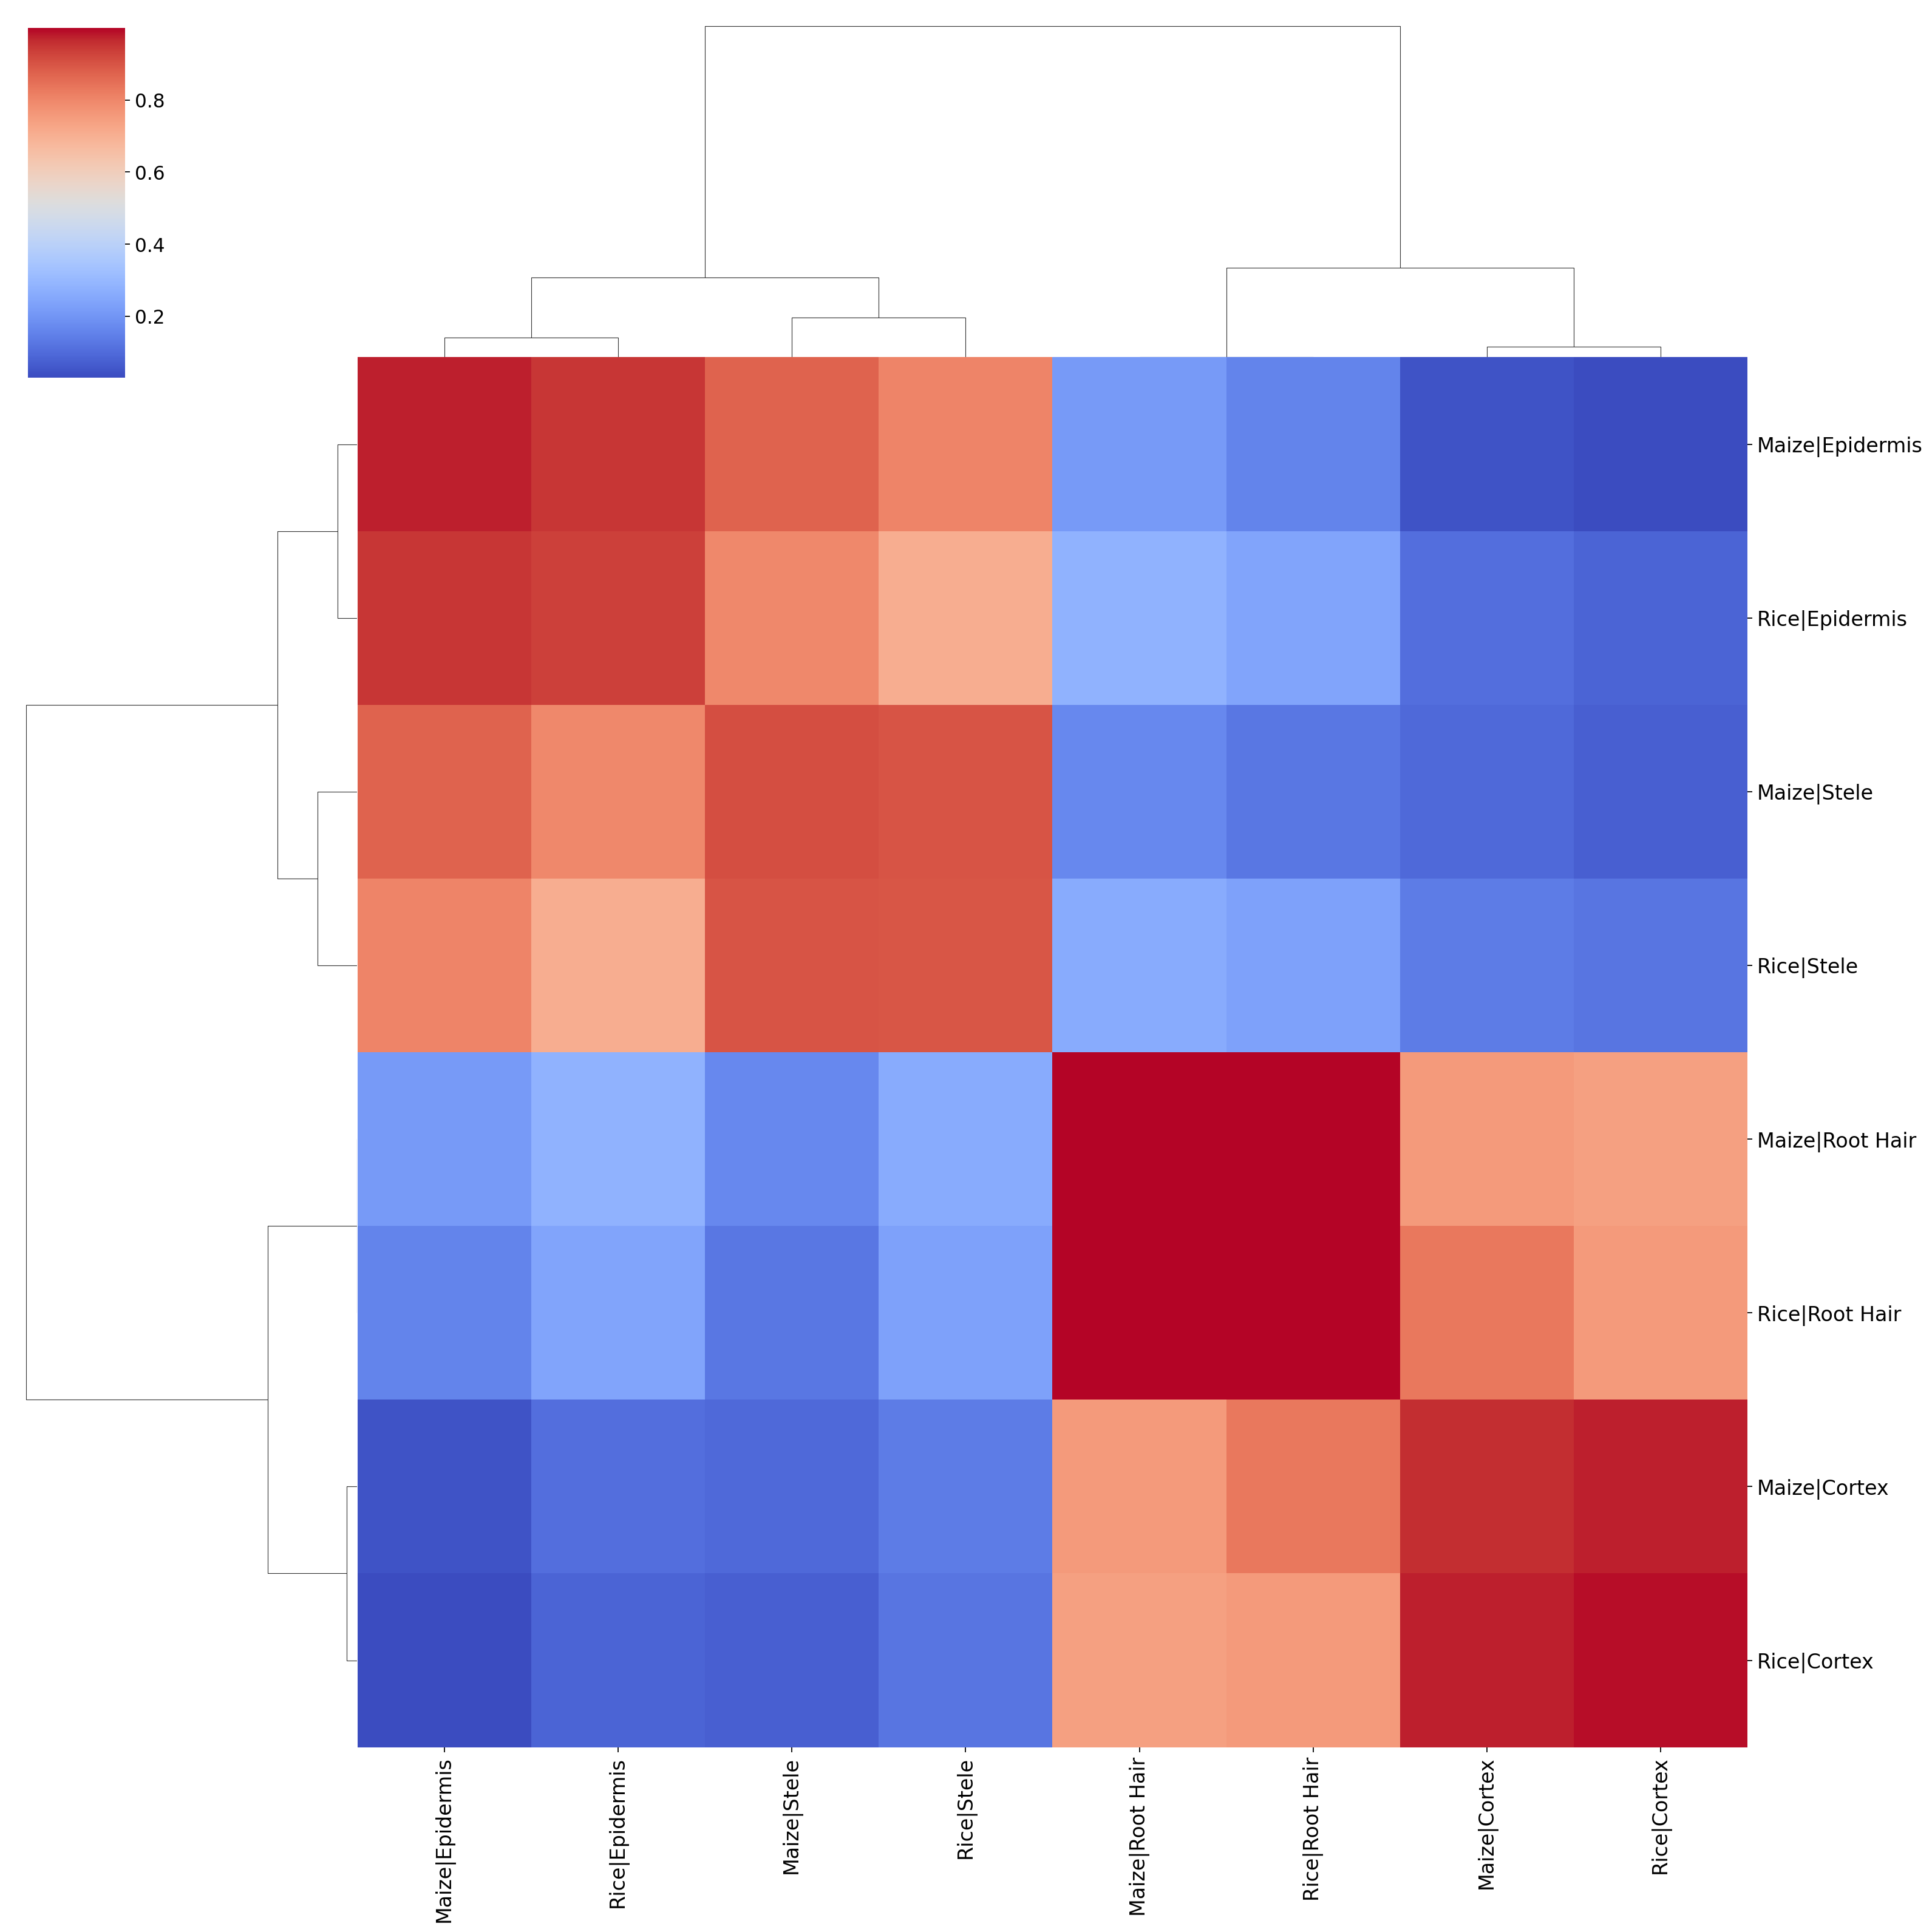

In [166]:
pymn.variableGenes(corrected_adata,study_col = 'Species')
pymn.MetaNeighborUS(corrected_adata,study_col = 'Species',ct_col = 'Cell Cluster Annotation')
g = pymn.plotMetaNeighborUS(corrected_adata,figsize = (20,20),cmap = 'coolwarm',fontsize = 15,show = False,)

In [167]:
corrected_adata.uns['MetaNeighborUS']

Maize|Cortex  Maize|Epidermis  Maize|Root Hair  Maize|Stele  \
Maize|Cortex         0.959145         0.047280         0.756052     0.095746   
Maize|Epidermis      0.047280         0.975720         0.212051     0.874796   
Maize|Root Hair      0.756052         0.212051         0.999808     0.166713   
Maize|Stele          0.095746         0.874796         0.166713     0.910208   
Rice|Cortex          0.973668         0.029645         0.739807     0.073028   
Rice|Epidermis       0.105487         0.950148         0.280189     0.796342   
Rice|Root Hair       0.829629         0.156695         0.999870     0.125667   
Rice|Stele           0.138584         0.803121         0.257887     0.898002   

                 Rice|Cortex  Rice|Epidermis  Rice|Root Hair  Rice|Stele  
Maize|Cortex        0.973668        0.105487        0.829629    0.138584  
Maize|Epidermis     0.029645        0.950148        0.156695    0.803121  
Maize|Root Hair     0.739807        0.280189        0.999870    0.257887  
Maize|Stele         0.073028        0.796342        0.125667    0.898002  
Rice|Cortex         0.989767        0.083214        0.755744    0.122276  
Rice|Epidermis      0.083214        0.934867        0.238986    0.706404  
Rice|Root Hair      0.755744        0.238986        0.999954    0.233281  
Rice|Stele          0.122276        0.706404        0.233281    0.894539

In [118]:
g.savefig('/data/passala/Plots_for_projects/Coexpressolog_paper_plots/updated_for_v11/v11_rice_maize_one_one_metaneighbor.svg')